In [1]:
import os

import pandas as pd
import numpy as np

from skimage import io
from skimage.filters import threshold_otsu
from skimage.measure import label
from skimage.segmentation import watershed

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from byc import constants, files, plotting, database, segmentation, utilities, fitting_tools

plotting.set_styles(matplotlib, plt)

# Chapter 1: Introduction

# Chapter 2: System development

## Ratiometric Sensors

### Promoter and number of aptamers optimization

In [2]:
from byc import steady_state_analysis as ssa
from importlib import reload
reload(ssa)

<module 'byc.steady_state_analysis' from 'C:\\Users\\johnp\\Dropbox\\Projects\\byc\\byc\\steady_state_analysis.py'>

In [183]:
exptname = '20231007_promoter_n_aptamers_optimization_from_2019'
# ssa.convert_nd2_files(exptname)

In [185]:
from byc import files
mdf = files.make_ss_mdf(exptname, sample_file_type='tif')

Found dataset directory at 
C:\Users\johnp\Box\Finkelstein-Matouschek\images\20231007_promoter_n_aptamers_optimization_from_2019\data
Saved master index df at
C:\Users\johnp\Box\Finkelstein-Matouschek\images\20231007_promoter_n_aptamers_optimization_from_2019\20231007_master_index.csv


In [187]:
reload(ssa)
mdfpath = r"C:\Users\johnp\Box\Finkelstein-Matouschek\images\20231007_promoter_n_aptamers_optimization_from_2019\20231007_master_index.csv"
mdfpath = mdfpath.replace('.csv', '_annotated.csv')
mdf = pd.read_csv(mdfpath)

In [195]:
# Backgrounds were set by manualy measuring and taking an average
# of non-cell areas in raw images
backgrounds = {
    '20190507': {
        'rfp': 143,
        'yfp': 131
    },
    '20190606': {
        'rfp': 197,
        'yfp': 134
    },
    '20190617': {
        'rfp': 210,
        'yfp': 165
    },
    '20191104': {
        'rfp': 850,
        'yfp': 312
    },
    '20191108': {
        'rfp': 309,
        'yfp': 163
    },
    '20191114': {
        'rfp': 350,
        'yfp': 190
    }
}

In [205]:
import re

# Read in all channel data in long format
# (row for each intensity measurement with a 
# column for which channel)
unfoundcsvs = []
channeldfs = []
for measdirname in mdf.measdirname:
    datafilepath = measdirname.replace('.tif', '.csv')
    if os.path.exists(datafilepath):
        channeldf = pd.read_csv(datafilepath)
        match = re.search(
            constants.patterns.channel_name,
            datafilepath[-8:]
        )

        if match:
            channelname = match.group()
        else:
            channelname = 'unknown-channel'
            
        channeldf.loc[:, 'channel'] = channelname
        # Label with data from the master index entry for
        # this sample
        for col in mdf.columns:
            if col not in list(channeldf.columns):
                channeldf.loc[:, col] = mdf.loc[
                    mdf.measdirname == measdirname,
                    col].iloc[0]
                      
        date = channeldf.date.iloc[0]
        if channelname in ['yfp', 'rfp']:
            background = backgrounds[str(date)][channelname]
            channeldf.loc[:, 'Mean_norm'] = channeldf.Mean/background              
                
        channeldfs.append(channeldf)
    else:
        unfoundcsvs.append(datafilepath)
alldf = pd.concat(channeldfs)

alldf.loc[alldf.tet_concn.isna(), 'tet_concn'] = '000uM-Tet'

### Promoter system optimization

Saved figure at
C:\Users\johnp\Dropbox\Projects\byc\data\meta\plots\x=plasmid_y=Mean_norm_hue=channel_dodge=True.svg


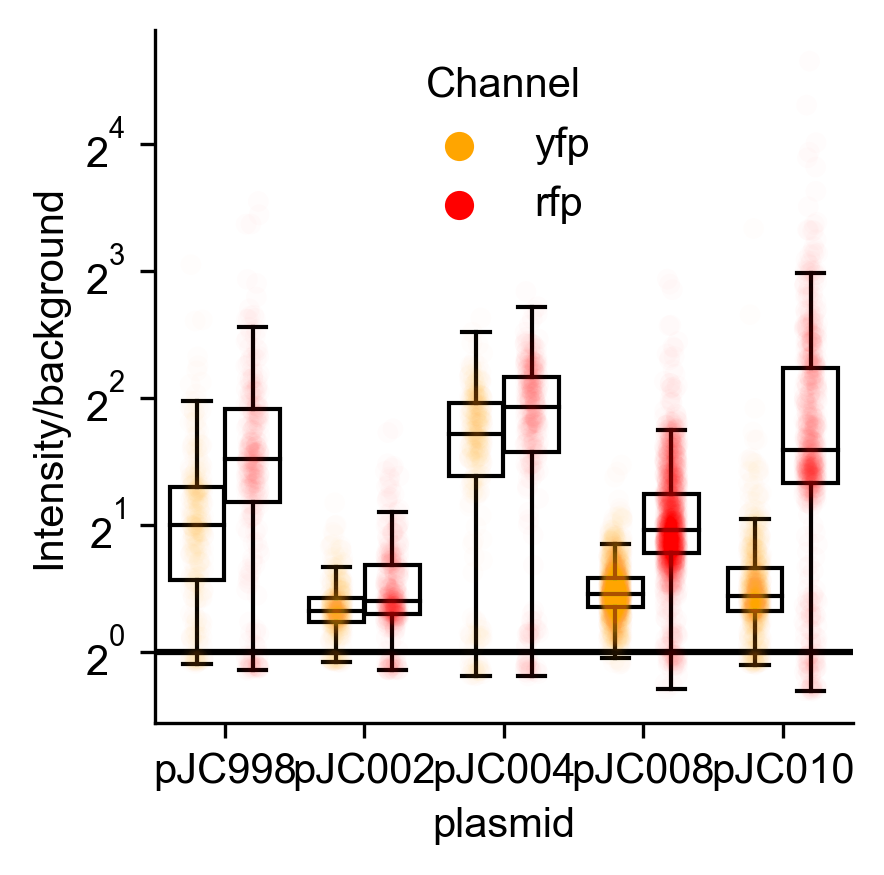

In [285]:
fig, ax = plotting.figure_ax(width_scale=1.5, height_scale=1.5)
fig.set_dpi(300)

plasmids = [
    'pJC999',
    'pJC998',
    'pJC001',
    'pJC002',
    'pJC003',
    'pJC004',
    'pJC008',
    'pJC009',
    'pJC010'
]

plasmids = [
    'pJC998',
    'pJC002',
    'pJC004',
    'pJC008',
    'pJC010'
]

kwargs = {
    'x': 'plasmid',
    'y': 'Mean_norm',
    'hue': 'channel',
    'palette': ['orange', 'red'],
    'hue_order': ['yfp', 'rfp'],
    'data': alldf[
        (alldf.genotype.isin(['pdr5d', 'BY4741']))
        &(alldf.tet_concn=='000uM-Tet')
        &(alldf.plasmid.isin(plasmids))],
    'ax': ax,
    'order': plasmids,
    'dodge': True
}


sns.boxplot(**kwargs, showfliers=False, **plotting.transparent_boxes_prop_dict)
sns.stripplot(**kwargs, linewidth=0, alpha=0.01)
ax.axhline(1, color='black')
ax.set_yscale('log', base=2)
ax.set_ylabel('Intensity/background')
ax.legend(ax.get_legend_handles_labels()[0][2:4],
          ax.get_legend_handles_labels()[1][2:4],
          frameon=False,
          title='Channel')
plotting.save_figure(fig, kwargs, ext='.svg')
ax.set_yscale('log', base=2)

### Aptamer number optimization

Saved figure at
C:\Users\johnp\Dropbox\Projects\byc\data\meta\plots\x=plasmid_y=Mean_norm_hue=channel_dodge=True.svg


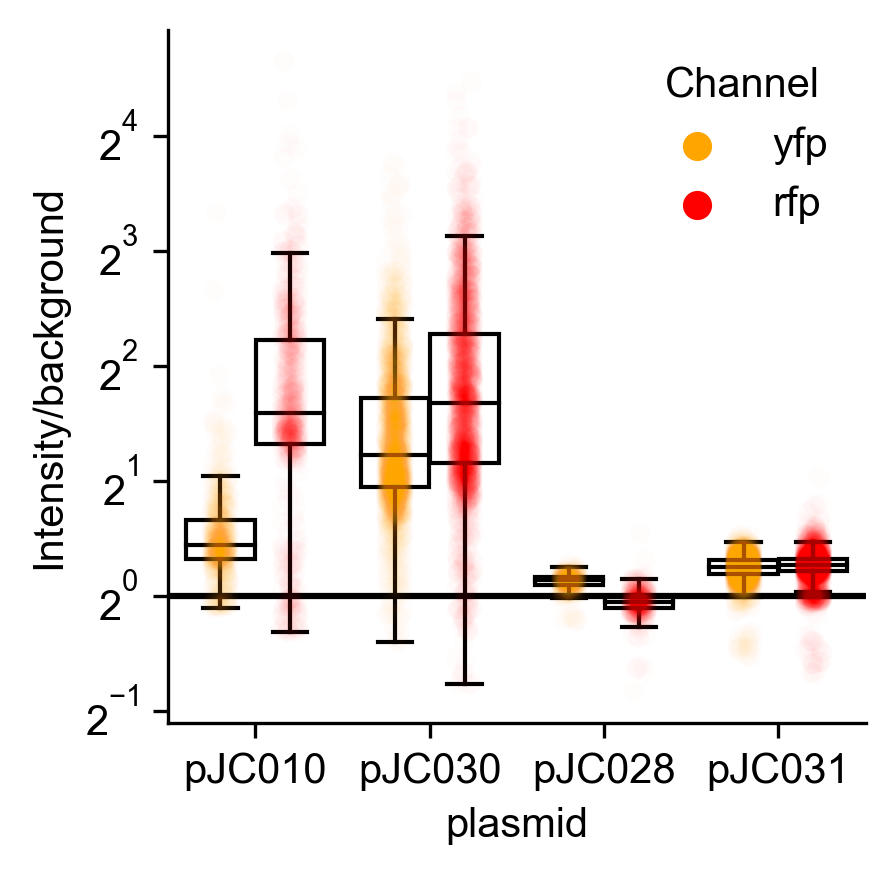

In [286]:
fig, ax = plotting.figure_ax(width_scale=1.5, height_scale=1.5)
fig.set_dpi(300)
plasmids = [
    'pJC010',
    'pJC030',
    'pJC028',
    'pJC031',
]

kwargs = {
    'x': 'plasmid',
    'y': 'Mean_norm',
    'hue': 'channel',
    'palette': ['orange', 'red'],
    'hue_order': ['yfp', 'rfp'],
    'data': alldf[
        (alldf.genotype.isin(['pdr5d', 'BY4741']))
        &(alldf.tet_concn=='000uM-Tet')
        &(alldf.plasmid.isin(plasmids))],
    'ax': ax,
    'order': plasmids,
    'dodge': True
}

sns.boxplot(**kwargs, showfliers=False, **plotting.transparent_boxes_prop_dict)
sns.stripplot(**kwargs, linewidth=0, alpha=0.01)
ax.axhline(1, color='black')
ax.set_yscale('log', base=2)
ax.set_ylabel('Intensity/background')
ax.legend(ax.get_legend_handles_labels()[0][2:4],
          ax.get_legend_handles_labels()[1][2:4],
          frameon=False,
          title='Channel')
plotting.save_figure(fig, kwargs, ext='.svg')

### Tetracycline response

Saved figure at
C:\Users\johnp\Dropbox\Projects\byc\data\meta\plots\x=plasmid_y=Mean_norm_hue=tet_concn_dodge=True.svg


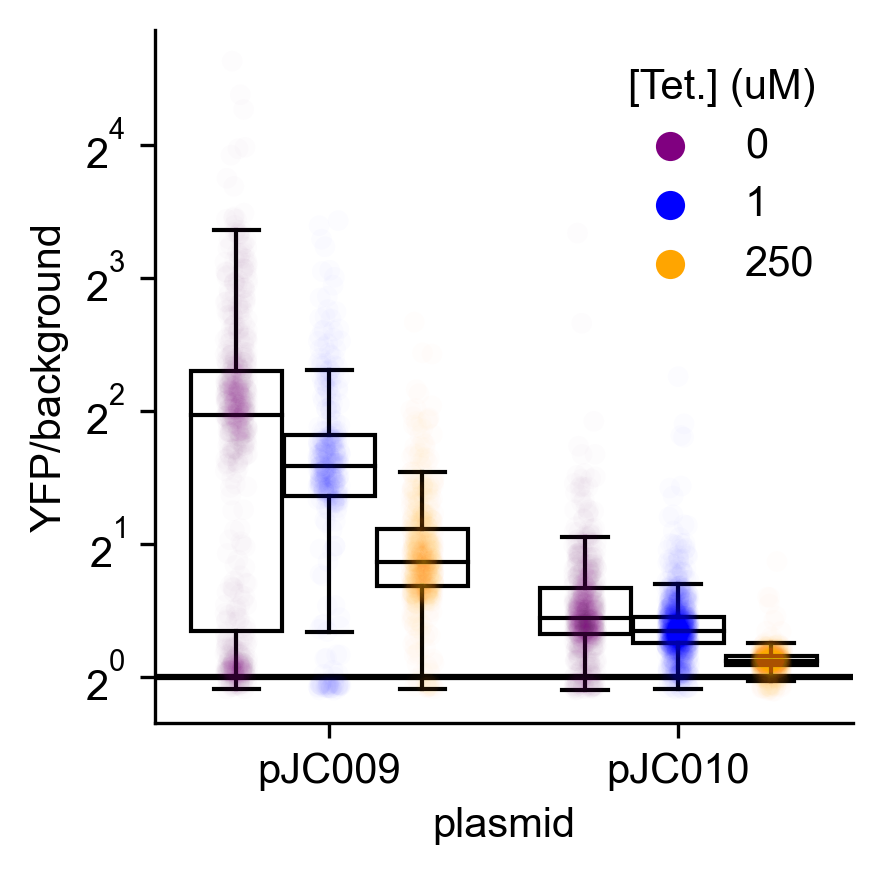

In [278]:
fig, ax = plotting.figure_ax(width_scale=1.5, height_scale=1.5)
fig.set_dpi(300)
plasmids = [
    'pJC009',
    'pJC010',
]

kwargs = {
    'x': 'plasmid',
    'y': 'Mean_norm',
    'hue': 'tet_concn',
    'palette': ['purple', 'blue', 'orange'],
    'data': alldf[
        (alldf.channel=='yfp')
        &(alldf.genotype.isin(['pdr5d', 'BY4741']))
        &(alldf.plasmid.isin(plasmids))],
    'ax': ax,
    'order': plasmids,
    'dodge': True
}

sns.boxplot(**kwargs, showfliers=False, **plotting.transparent_boxes_prop_dict)
sns.stripplot(**kwargs, linewidth=0, alpha=0.01)
ax.axhline(1, color='black')
ax.set_yscale('log', base=2)
ax.set_ylabel('YFP/background')
# ax.set_ylim(0, 10)
ax.legend(ax.get_legend_handles_labels()[0][3:6],
          [0, 1, 250],
          frameon=False,
          title='[Tet.] (uM)')
plotting.save_figure(fig, kwargs, ext='.svg')

Saved figure at
C:\Users\johnp\Dropbox\Projects\byc\data\meta\plots\x=plasmid_y=Mean_norm_hue=tet_concn_dodge=True.svg


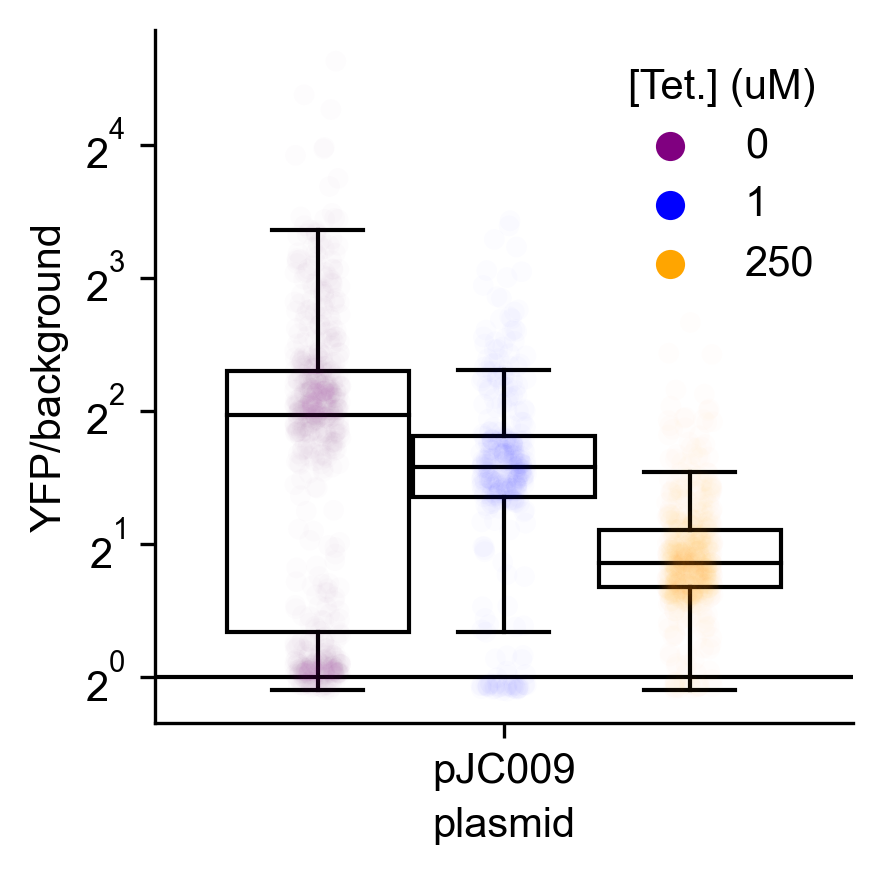

In [288]:
fig, ax = plotting.figure_ax(width_scale=1.5, height_scale=1.5)
fig.set_dpi(300)
plasmids = [
    'pJC009',
]

kwargs = {
    'x': 'plasmid',
    'y': 'Mean_norm',
    'hue': 'tet_concn',
    'palette': ['purple', 'blue', 'orange'],
    'data': alldf[
        (alldf.channel=='yfp')
        &(alldf.genotype.isin(['pdr5d', 'BY4741']))
        &(alldf.plasmid.isin(plasmids))],
    'ax': ax,
    'order': plasmids,
    'dodge': True
}

sns.boxplot(**kwargs, showfliers=False, **plotting.transparent_boxes_prop_dict)
sns.stripplot(**kwargs, linewidth=0, alpha=0.01)
ax.axhline(1, color='black', linewidth=1)
ax.set_yscale('log', base=2)
ax.set_ylabel('YFP/background')
# ax.set_ylim(0.9, 2.5)
ax.legend(ax.get_legend_handles_labels()[0][3:6],
          [0, 1, 250],
          frameon=False,
          title='[Tet.] (uM)')
plotting.save_figure(fig, kwargs, ext='.svg')

Saved figure at
C:\Users\johnp\Dropbox\Projects\byc\data\meta\plots\x=plasmid_y=Mean_norm_hue=tet_concn_dodge=True.svg


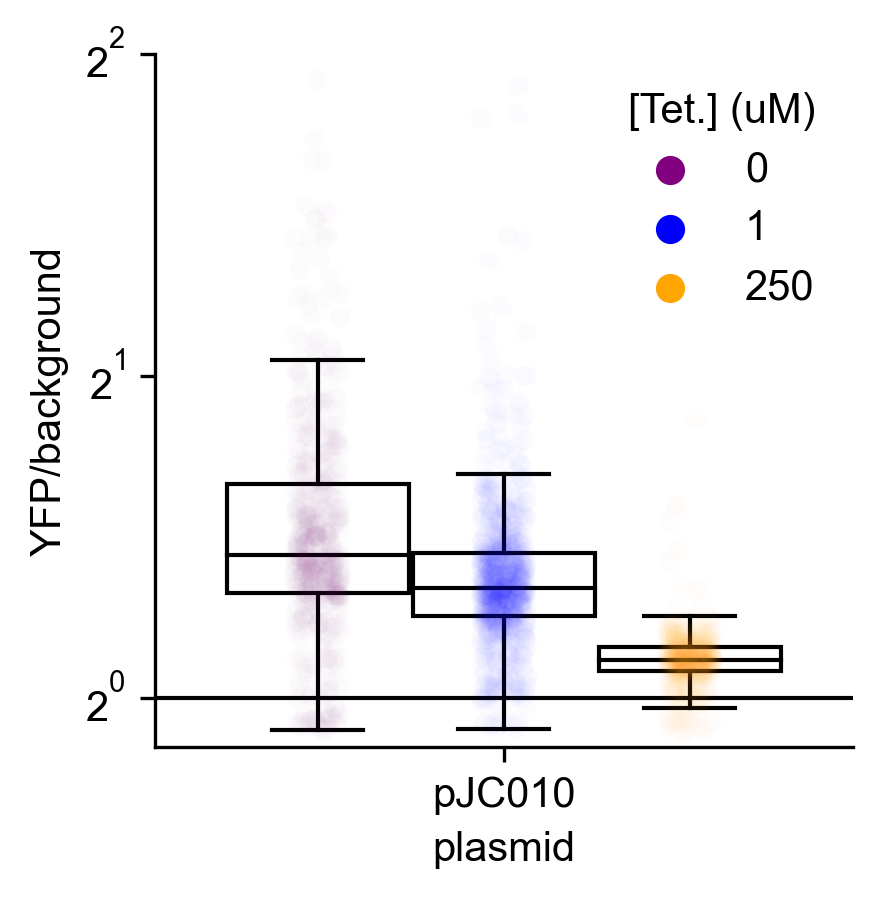

In [290]:
fig, ax = plotting.figure_ax(width_scale=1.5, height_scale=1.5)
fig.set_dpi(300)
plasmids = [
    'pJC010',
]

kwargs = {
    'x': 'plasmid',
    'y': 'Mean_norm',
    'hue': 'tet_concn',
    'palette': ['purple', 'blue', 'orange'],
    'data': alldf[
        (alldf.channel=='yfp')
        &(alldf.genotype.isin(['pdr5d', 'BY4741']))
        &(alldf.plasmid.isin(plasmids))],
    'ax': ax,
    'order': plasmids,
    'dodge': True
}

sns.boxplot(**kwargs, showfliers=False, **plotting.transparent_boxes_prop_dict)
sns.stripplot(**kwargs, linewidth=0, alpha=0.01)
ax.axhline(1, color='black', linewidth=1)
ax.set_yscale('log', base=2)
ax.set_ylabel('YFP/background')
ax.set_ylim(0.9, 4)
ax.legend(ax.get_legend_handles_labels()[0][3:6],
          [0, 1, 250],
          frameon=False,
          title='[Tet.] (uM)')
plotting.save_figure(fig, kwargs, ext='.svg')

### Substrate panel characterization examples: Steady state cover slip imaging

Combines two experiments

In [5]:
%%capture readin_printout

import glob, os

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
params = {'mathtext.default': 'regular',
          
          'font.sans-serif': 'Arial'}          
plt.rcParams.update(params)

from byc import steady_state_analysis as ssa
from byc import plotting, constants

substrates_index_path = os.path.join(constants.steady_state_data_dir, 'meta_analysis/Analysis/Substrates_Index.csv')
substrates_index = pd.read_csv(substrates_index_path)
mdf_path = os.path.join(constants.steady_state_data_dir, "20210728_429_431_432_482_483_484_485_486_487_BY4741_CMY3465_rpn4d\\20210728_master_index_old.csv")
mdf = pd.read_csv(mdf_path)
alldf = ssa.make_expt_df(mdf_path, bg_channel='rfp', filter_cells=False)

mdf_path1 = os.path.join(constants.steady_state_data_dir, "20210909_Ub_Uba1_Rad6_OE_JPC121_pJC485_CMY3465\\20210909_master_index.csv")
mdf1 = pd.read_csv(mdf_path1)
alldf1 = ssa.make_expt_df(mdf_path1, bg_channel='rfp', filter_cells=False)

Saved figure at
C:\Users\johnp\Dropbox\Projects\byc\data\meta\plots\x=copy_number_y=yfp_norm_hue=background_dodge=True.svg


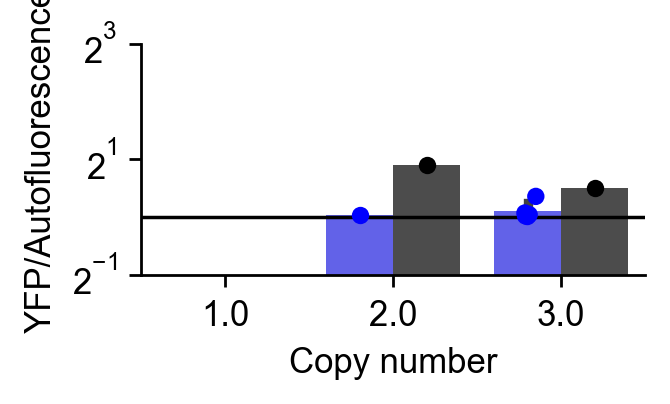

In [29]:
fulldf = pd.concat([alldf, alldf1])
fulldf.loc[:, 'background_clone'] = fulldf.genotype.str.cat(fulldf.clone_number.astype(str), sep='_')
fulldf.loc[fulldf.genotype.isin(['CMY3465', 'BY4741']), 'background'] = 'WT'
fulldf.loc[fulldf.genotype.isin(['rpn4d']), 'background'] = 'rpn4d'
plasmids = [
    'pJC484',
    'pJC485'
]
booldex = (fulldf.plasmid.isin(plasmids)) & (fulldf.genotype.isin(['rpn4d', 'CMY3465']))
aggdex = [
    'plasmid',
    'background_clone',
    'copy_number',
    'genotype',
    'background'
]


fig, ax = plotting.figure_ax(height_scale=0.6, width_scale=1.3)
x_order = [1.0, 2.0, 3.0]
hue_order = ['WT', 'rpn4d']

table = fulldf[booldex].loc[:, ['yfp_norm'] + aggdex].groupby(aggdex, as_index=False).mean()
kwargs = {
    'x': 'copy_number',
    'y': 'yfp_norm',
    'hue': 'background',
    'data': table,
    'dodge': True,
    'hue_order': hue_order,
    'order': x_order,
    'ax': ax,
    'palette': ['blue', 'black']
}

sns.stripplot(**kwargs)
sns.barplot(**kwargs, alpha=0.7)
ax.set_yscale('log', base=2)
ax.set_yticks([0.5, 2, 8])
ax.set_ylim(0.5, 8)
ax.set_ylabel('YFP/Autofluorescence')
ax.set_xlabel('Copy number')
ax.legend_.set_visible(False)
ax.axhline(1, color='black', linewidth=1)
plotting.save_figure(fig, kwargs, ext='.svg')

One experiment

In [55]:
%%capture readin_printout

import glob, os

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
params = {'mathtext.default': 'regular',
          
          'font.sans-serif': 'Arial'}          
plt.rcParams.update(params)

from byc import steady_state_analysis as ssa
from byc import plotting, constants

substrates_index_path = os.path.join(constants.steady_state_data_dir, 'meta_analysis/Analysis/Substrates_Index.csv')
substrates_index = pd.read_csv(substrates_index_path)
mdf_path = os.path.join(constants.steady_state_data_dir, "20210831_pJC359_380_BY4741/20210831_master_index.csv")
mdf = pd.read_csv(mdf_path)
alldf = ssa.make_expt_df(mdf_path, bg_channel='rfp', filter_cells=False)

Text(0.5, 1.0, 'BY4741')

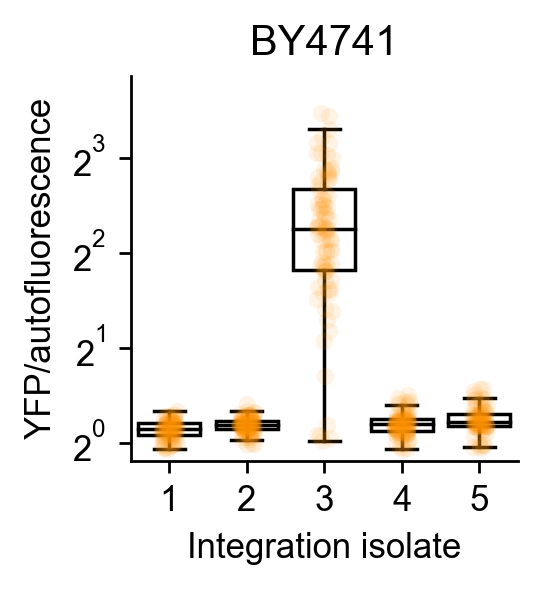

In [56]:
fig, ax = plotting.figure_ax()

kwargs = {
    'x': 'clone_number',
    'y': 'yfp_norm',
    'ax': ax,
    'data': alldf[alldf.plasmid=='pJC359'],
}

sns.stripplot(**kwargs, color=plotting.strains_color_dict['JPC121'], alpha=0.1)
sns.boxplot(**kwargs, **plotting.transparent_boxes_prop_dict, showfliers=False)

ax.set_yscale('log', base=2)
ax.set_ylabel('YFP/autofluorescence')
ax.set_xlabel('Integration isolate')
ax.set_ylim((0.875594148914947, 14.53840431051804))

ax.set_title('BY4741')

In [59]:
%%capture readin_printout

import glob, os

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
params = {'mathtext.default': 'regular',
          
          'font.sans-serif': 'Arial'}          
plt.rcParams.update(params)

from byc import steady_state_analysis as ssa
from byc import plotting, constants

substrates_index_path = os.path.join(constants.steady_state_data_dir, 'meta_analysis/Analysis/Substrates_Index.csv')
substrates_index = pd.read_csv(substrates_index_path)
mdf_path = os.path.join(constants.steady_state_data_dir, "20230221_pJC359_pJC380_ubr2d_rpn4d_BY4741/20230221_master_index.csv")
mdf = pd.read_csv(mdf_path)
alldf = ssa.make_expt_df(mdf_path, bg_channel='rfp', filter_cells=False)
yfp_bg = 117
alldf.loc[:, 'yfp_norm'] = alldf.yfp_mean/yfp_bg

Text(0.5, 1.0, '$\\it{ubr2}$$\\Delta$')

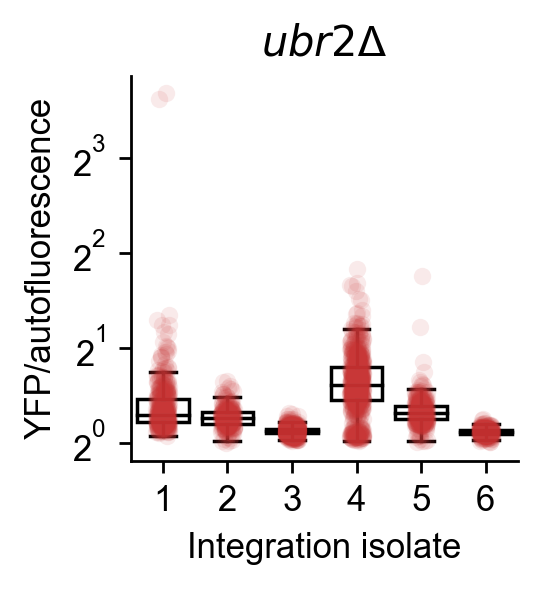

In [60]:
fig, ax = plotting.figure_ax()

kwargs = {
    'x': 'clone',
    'y': 'yfp_norm',
    'ax': ax,
    'data': alldf[(alldf.plasmid=='pJC359')&(alldf.genotype=='ubr2d')],
}

sns.stripplot(**kwargs, color=plotting.strains_color_dict['JPC262'], alpha=0.1)
sns.boxplot(**kwargs, **plotting.transparent_boxes_prop_dict, showfliers=False)

ax.set_yscale('log', base=2)
ax.set_ylabel('YFP/autofluorescence')
ax.set_xlabel('Integration isolate')
ax.set_ylim((0.875594148914947, 14.53840431051804))
ax.set_title(plotting.get_gene_deletion_string('ubr2'))

In [68]:
%%capture readin_printout

import glob, os

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
params = {'mathtext.default': 'regular',
          
          'font.sans-serif': 'Arial'}          
plt.rcParams.update(params)

from byc import steady_state_analysis as ssa
from byc import plotting, constants

substrates_index_path = os.path.join(constants.steady_state_data_dir, 'meta_analysis/Analysis/Substrates_Index.csv')
substrates_index = pd.read_csv(substrates_index_path)
mdf_path = os.path.join(constants.steady_state_data_dir, "20230510_transformants_05042023/20230510_master_index.csv")
mdf = pd.read_csv(mdf_path)
alldf = ssa.make_expt_df(mdf_path, bg_channel='rfp', filter_cells=False)
yfp_bg = 119
alldf.loc[:, 'yfp_norm'] = alldf.yfp_mean/yfp_bg

Text(0.5, 1.0, '$\\it{mub1d}$$\\Delta$')

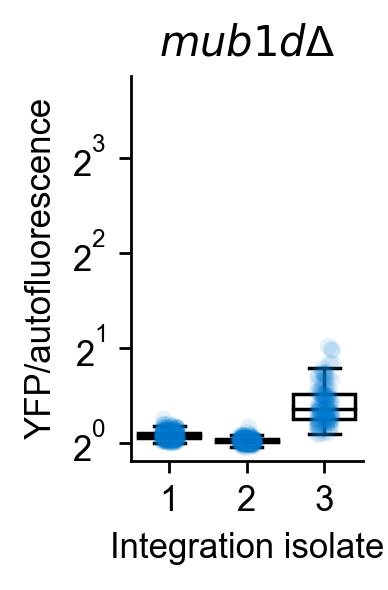

In [70]:
fig, ax = plotting.figure_ax(width_scale=3/5)

kwargs = {
    'x': 'clone',
    'y': 'yfp_norm',
    'ax': ax,
    'data': alldf[(alldf.plasmid=='pJC359')&(alldf.genotype=='mub1d')],
}

sns.stripplot(**kwargs, color=plotting.strains_color_dict['JPC274'], alpha=0.1)
sns.boxplot(**kwargs, **plotting.transparent_boxes_prop_dict, showfliers=False)

ax.set_yscale('log', base=2)
ax.set_ylabel('YFP/autofluorescence')
ax.set_xlabel('Integration isolate')
ax.set_ylim((0.875594148914947, 14.53840431051804))
ax.set_title(plotting.get_gene_deletion_string('mub1d'))

### Older steady state data that needs modifications to the master index

In [149]:
%%capture readin_printout

import glob, os

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
params = {'mathtext.default': 'regular',
          
          'font.sans-serif': 'Arial'}          
plt.rcParams.update(params)

from byc import steady_state_analysis as ssa
from byc import plotting, constants

substrates_index_path = os.path.join(constants.steady_state_data_dir, 'meta_analysis/Analysis/Substrates_Index.csv')
substrates_index = pd.read_csv(substrates_index_path)
mdf_path = os.path.join(constants.steady_state_data_dir, r"20210312_pJC248_249_rpn4d_271_BY4741_rpn4d_272_273_rpn4d\20210312_master_index.csv")
mdf = pd.read_csv(mdf_path)
# Because this is old data I need to repair the master indices
datadir = os.path.join(os.path.dirname(mdf_path), 'data')
alltifs = [fn for fn in os.listdir(datadir) if fn[-4:] == '.tif']
tifs_no_channel = [fn[0:fn.rindex('_00')] + '_1' for fn in alltifs]
measdirnames = np.unique(tifs_no_channel)
mdf.loc[:, 'measdirname'] = [os.path.join(datadir, name) for name in measdirnames]
mdf.to_csv(mdf_path)
alldf = ssa.make_expt_df(mdf_path, bg_channel='rfp', filter_cells=False)
alldf.loc[:, 'date'] = '20210312'
# Don't want BY4741 data from this 
alldf = alldf[alldf.genotype=='rpn4d']

# These are marked as BY4741 background but they were actually CMY3465 magic marker strain
mdf_path1 = os.path.join(constants.steady_state_data_dir, r"20210212_pJC271_272_273_magic\20210212_master_index.csv")
mdf1 = pd.read_csv(mdf_path1)
datadir = os.path.join(os.path.dirname(mdf_path1), 'data')
alltifs = [fn for fn in os.listdir(datadir) if fn[-4:] == '.tif']
tifs_no_channel = [fn[0:fn.rindex('_00')] + '_1' for fn in alltifs]
measdirnames = np.unique(tifs_no_channel)
mdf1.loc[:, 'measdirname'] = [os.path.join(datadir, name) for name in measdirnames]
mdf1.to_csv(mdf_path1)
alldf1 = ssa.make_expt_df(mdf_path1, bg_channel='rfp', filter_cells=False)
alldf1.loc[:, 'date'] = '20210212'

Saved figure at
C:\Users\johnp\Dropbox\Projects\byc\data\meta\plots\x=copy_number_y=rfp_norm_hue=background_dodge=True.svg


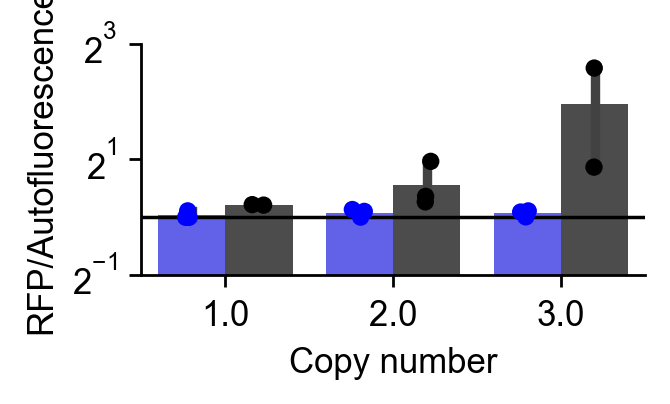

In [152]:
fulldf = pd.concat([alldf, alldf1])
fulldf.loc[:, 'background_clone'] = fulldf.genotype.str.cat(fulldf.clone.astype(str), sep='_')
fulldf.loc[fulldf.genotype.isin(['CMY3465', 'BY4741']), 'background'] = 'WT'
fulldf.loc[fulldf.genotype.isin(['rpn4d']), 'background'] = 'rpn4d'
plasmids = [
    'pJC271',
    'pJC272',
    'pJC273'
]
booldex = (fulldf.plasmid.isin(plasmids)) & (fulldf.genotype.isin(['rpn4d', 'BY4741']))
aggdex = [
    'plasmid',
    'background_clone',
    'copy_number',
    'genotype',
    'background'
]


fig, ax = plotting.figure_ax(height_scale=0.6, width_scale=1.3)
x_order = [1.0, 2.0, 3.0]
hue_order = ['WT', 'rpn4d']

table = fulldf[booldex].loc[:, ['rfp_norm'] + aggdex].groupby(aggdex, as_index=False).mean()
kwargs = {
    'x': 'copy_number',
    'y': 'rfp_norm',
    'hue': 'background',
    'data': table,
    'dodge': True,
    'hue_order': hue_order,
    'ax': ax,
    'palette': ['blue', 'black']
}

sns.stripplot(**kwargs)
sns.barplot(**kwargs, alpha=0.7)
ax.set_yscale('log', base=2)
ax.set_yticks([0.5, 2, 8])
ax.set_ylim(0.5, 8)
ax.set_ylabel('RFP/Autofluorescence')
ax.set_xlabel('Copy number')
ax.legend_.set_visible(False)
ax.axhline(1, color='black', linewidth=1)
plotting.save_figure(fig, kwargs, ext='.svg')

### Flow cytometry data

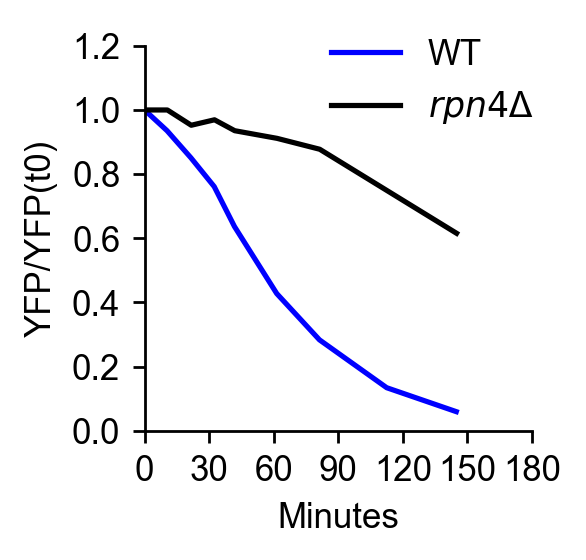

In [153]:
path = r'C:\Users\johnp\Box\Finkelstein-Matouschek\flow_cytometry\20210804\20210804_data_agg.csv'
df = pd.read_csv(path)
fig, ax = plotting.figure_ax()
plasmids = ['pJC485']
kwargs = {
    'x': 'minutes',
    'y': 'yfp_norm',
    'hue': 'genotype',
    'data': df[df.plasmid.isin(plasmids)],
    'ax': ax,
    'hue_order': ['BY4741', 'rpn4d'],
    'palette': ['blue', 'black']
}

sns.lineplot(**kwargs)
# ax.legend_.set_visible(False)
labels = [
    'WT',
    plotting.get_gene_deletion_string('rpn4')
]
ax.legend(ax.get_legend_handles_labels()[0], labels, frameon=False, title='', bbox_to_anchor=(0.4, 1.1))
ax.set_xlim(0, 180)
ax.set_xticks(np.arange(0, 181, 30))
ax.set_xlabel('Minutes')
ax.set_ylabel('YFP/YFP(t0)')
ax.set_ylim(0, 1.2)
ax.set_yticks(np.arange(0, 1.21, 0.2))

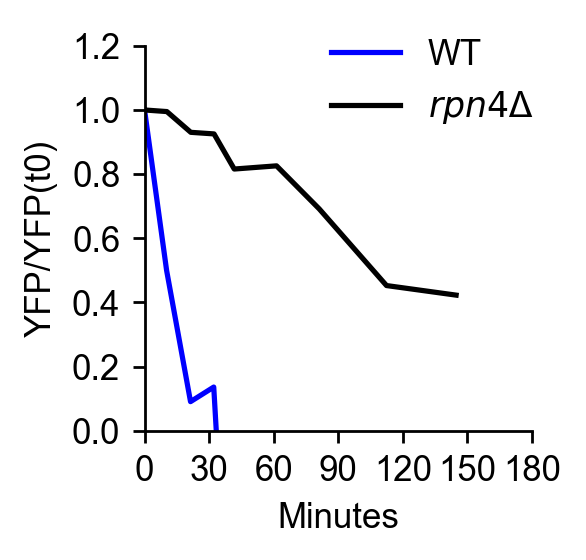

In [59]:
path = r'C:\Users\johnp\Box\Finkelstein-Matouschek\flow_cytometry\20210804\20210804_data_agg.csv'
df = pd.read_csv(path)
fig, ax = plotting.figure_ax()
plasmids = ['pJC482']
kwargs = {
    'x': 'minutes',
    'y': 'yfp_norm',
    'hue': 'genotype',
    'data': df[df.plasmid.isin(plasmids)],
    'ax': ax,
    'hue_order': ['BY4741', 'rpn4d'],
    'palette': ['blue', 'black']
}

sns.lineplot(**kwargs)
# ax.legend_.set_visible(False)
labels = [
    'WT',
    plotting.get_gene_deletion_string('rpn4')
]
ax.legend(ax.get_legend_handles_labels()[0], labels, frameon=False, title='', bbox_to_anchor=(0.4, 1.1))
ax.set_xlim(0, 180)
ax.set_xticks(np.arange(0, 181, 30))
ax.set_xlabel('Minutes')
ax.set_ylabel('YFP/YFP(t0)')
ax.set_ylim(0, 1.2)
ax.set_yticks(np.arange(0, 1.21, 0.2))

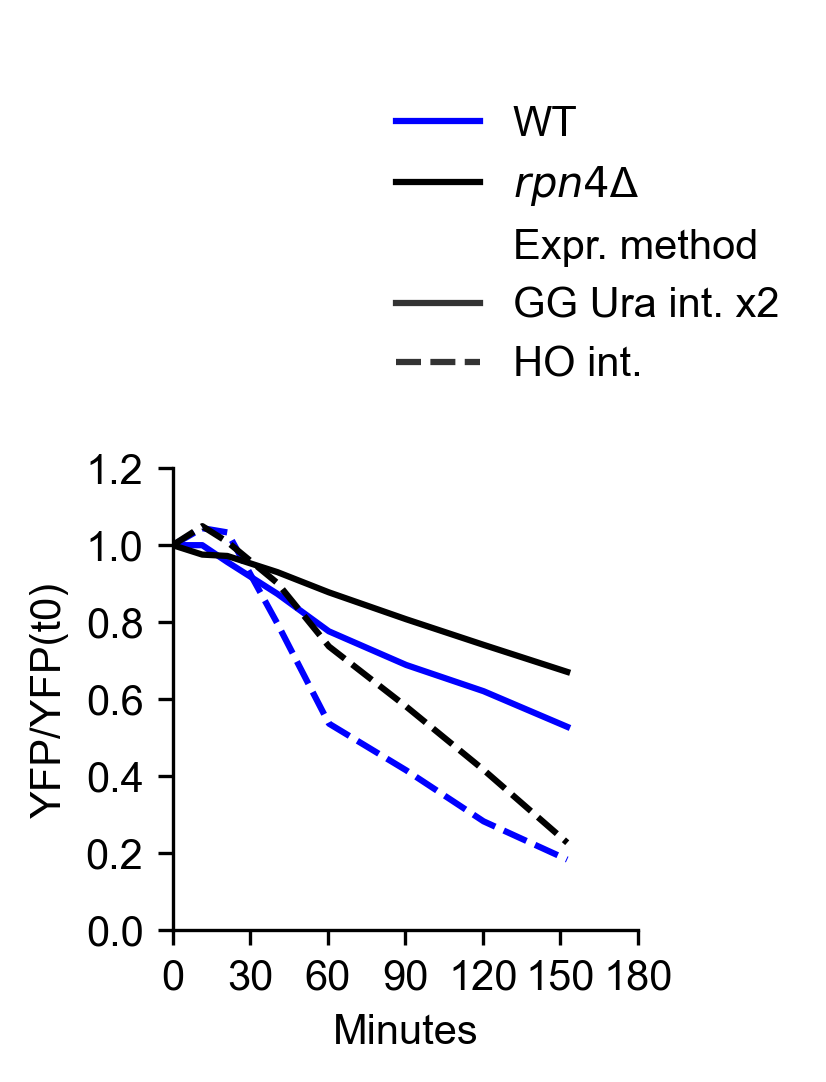

In [4]:
path = r'C:\Users\johnp\Box\Finkelstein-Matouschek\flow_cytometry\20210430\20210430_data_agg.csv'
df = pd.read_csv(path)
fig, ax = plotting.figure_ax()
fig.set_dpi(300)
plasmids = ['pJC334', 'pJC031']
kwargs = {
    'x': 'minutes',
    'y': 'yfp_norm',
    'hue': 'background',
    'data': df[df.plasmid.isin(plasmids)&(df.minutes<160)],
    'style': 'plasmid',
    'ax': ax,
    'style_order': plasmids,
    'hue_order': ['BY4741', 'rpn4d'],
    'palette': ['blue', 'black']
}

sns.lineplot(**kwargs)
# ax.legend_.set_visible(False)
labels = [
    'WT',
    plotting.get_gene_deletion_string('rpn4')
]
labels = [
    '',
    'WT',
    plotting.get_gene_deletion_string('rpn4'),
    'Expr. method',
    'GG Ura int. x2',
    'HO int.'
]
ax.legend(ax.get_legend_handles_labels()[0], labels, frameon=False, title='', bbox_to_anchor=(0.4, 1.1))
# ax.legend_.set_visible(False)
ax.set_xlim(0, 180)
ax.set_xticks(np.arange(0, 181, 30))
ax.set_xlabel('Minutes')
ax.set_ylabel('YFP/YFP(t0)')
ax.set_ylim(0, 1.2)
ax.set_yticks(np.arange(0, 1.21, 0.2))

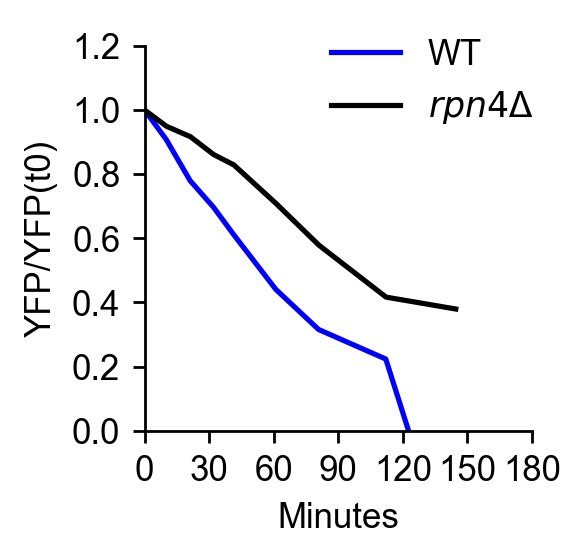

In [89]:
path = r'C:\Users\johnp\Box\Finkelstein-Matouschek\flow_cytometry\20210804\20210804_data_agg.csv'
df = pd.read_csv(path)
fig, ax = plotting.figure_ax()
plasmids = ['pJC431']
kwargs = {
    'x': 'minutes',
    'y': 'yfp_norm',
    'hue': 'genotype',
    'data': df[df.plasmid.isin(plasmids)],
    'ax': ax,
    'hue_order': ['BY4741', 'rpn4d'],
    'palette': ['blue', 'black']
}

sns.lineplot(**kwargs)
# ax.legend_.set_visible(False)
labels = [
    'WT',
    plotting.get_gene_deletion_string('rpn4')
]
ax.legend(ax.get_legend_handles_labels()[0], labels, frameon=False, title='', bbox_to_anchor=(0.4, 1.1))
ax.set_xlim(0, 180)
ax.set_xticks(np.arange(0, 181, 30))
ax.set_xlabel('Minutes')
ax.set_ylabel('YFP/YFP(t0)')
ax.set_ylim(0, 1.2)
ax.set_yticks(np.arange(0, 1.21, 0.2))

### Coverslip imaging to assess effect of growth condition on degradation of pJC031 UBL-YFP-NS in WT and *rpn4&Delta;* cells?

In [303]:
exptname = "20210421_pJC031_BY4741_rpn4d_timecourse"
exptdir = os.path.join(constants.steady_state_data_dir, exptname)
alldfpath = os.path.join(exptdir, 'alldf.csv')
alldf = pd.read_csv(alldfpath)
alldf.loc[:, 'hours'] = alldf.minutes/60
# Compensate for bleedthrough from YFP fluorophore into the RFP filter cube
alldf.loc[:, 'rfp_mean_yfp_comp'] = alldf.rfp_mean - alldf.yfp_mean*ssa.Constants().yfp_to_rfp_compensation_factor
# Define background value for each channel
yfpbg = alldf.loc[alldf.minutes==180, 'yfp_mean'].mean()
yfpbg = 175
rfpbg = 232
rfpbg_yfp_comp = rfpbg - yfpbg*ssa.Constants().yfp_to_rfp_compensation_factor
# rfpbg_yfp_comp = alldf.loc[alldf.minutes==180, 'rfp_mean_yfp_comp'].median()
# Substract backgrounds
alldf.loc[:, 'rfp_mean_comp_bgsub'] = alldf.rfp_mean_yfp_comp - rfpbg_yfp_comp
alldf.loc[:, 'yfp_mean_bgsub'] = alldf.yfp_mean - yfpbg

sample_conditions = [
    'culture_condition',
    'genotype'
]
alldf.set_index(sample_conditions, inplace=True)
unique_idxs = list(alldf.index.unique())
newcols = ['rfp_norm_t0', 'yfp_norm_t0']
for midx in unique_idxs:
    for i, col in  enumerate(['rfp_mean_comp_bgsub', 'yfp_mean_bgsub']):
        t0val = alldf.reset_index().set_index(sample_conditions + ['minutes']).loc[midx + (0,), col].mean()
        alldf.loc[midx, newcols[i]] = alldf.loc[midx, col]/t0val
        print(str(midx) + ', ' + str(col) + ', ' + str(t0val))
        
alldf.reset_index(inplace=True)
aggdex = [
    'minutes',
    'hours',
    'genotype',
    'culture_condition'
]
ycols = [
    'yfp_mean',
    'rfp_mean',
    'yfp_norm',
    'rfp_norm',
    'rfp_norm_t0',
    'yfp_norm_t0',
    'yfp_mean_bgsub',
    'rfp_mean_comp_bgsub',
    'rfp_mean_yfp_comp'
]
cols = [col for col in alldf.columns if alldf[col].dtype!='O']
cols = cols + [col for col in aggdex if col not in cols]
# aggdict = {}
# for col in ycols:
#     aggdict[col] = ['mean', 'median', 'std']
# table = alldf.groupby(aggdex, as_index=False).agg(aggdict)
table = alldf.groupby(aggdex, as_index=False)[ycols].mean()

('constantOD', 'BY4741'), rfp_mean_comp_bgsub, 67.40587730635885
('constantOD', 'BY4741'), yfp_mean_bgsub, 32.79320481927711
('RT', 'BY4741'), rfp_mean_comp_bgsub, 65.1832562990307
('RT', 'BY4741'), yfp_mean_bgsub, 33.1230707070707
('constantOD', 'rpn4d'), rfp_mean_comp_bgsub, 70.4523544494727
('constantOD', 'rpn4d'), yfp_mean_bgsub, 27.38703333333333
('RT', 'rpn4d'), rfp_mean_comp_bgsub, 94.73187963845484
('RT', 'rpn4d'), yfp_mean_bgsub, 38.989105263157896


C:\Users\johnp\AppData\Local\Temp\ipykernel_14180\1220225862.py:27: PerformanceWarning: indexing past lexsort depth may impact performance.
  t0val = alldf.reset_index().set_index(sample_conditions + ['minutes']).loc[midx + (0,), col].mean()
C:\Users\johnp\AppData\Local\Temp\ipykernel_14180\1220225862.py:28: PerformanceWarning: indexing past lexsort depth may impact performance.
  alldf.loc[midx, newcols[i]] = alldf.loc[midx, col]/t0val
C:\Users\johnp\AppData\Local\Temp\ipykernel_14180\1220225862.py:27: PerformanceWarning: indexing past lexsort depth may impact performance.
  t0val = alldf.reset_index().set_index(sample_conditions + ['minutes']).loc[midx + (0,), col].mean()
C:\Users\johnp\AppData\Local\Temp\ipykernel_14180\1220225862.py:28: PerformanceWarning: indexing past lexsort depth may impact performance.
  alldf.loc[midx, newcols[i]] = alldf.loc[midx, col]/t0val
C:\Users\johnp\AppData\Local\Temp\ipykernel_14180\1220225862.py:27: PerformanceWarning: indexing past lexsort depth ma

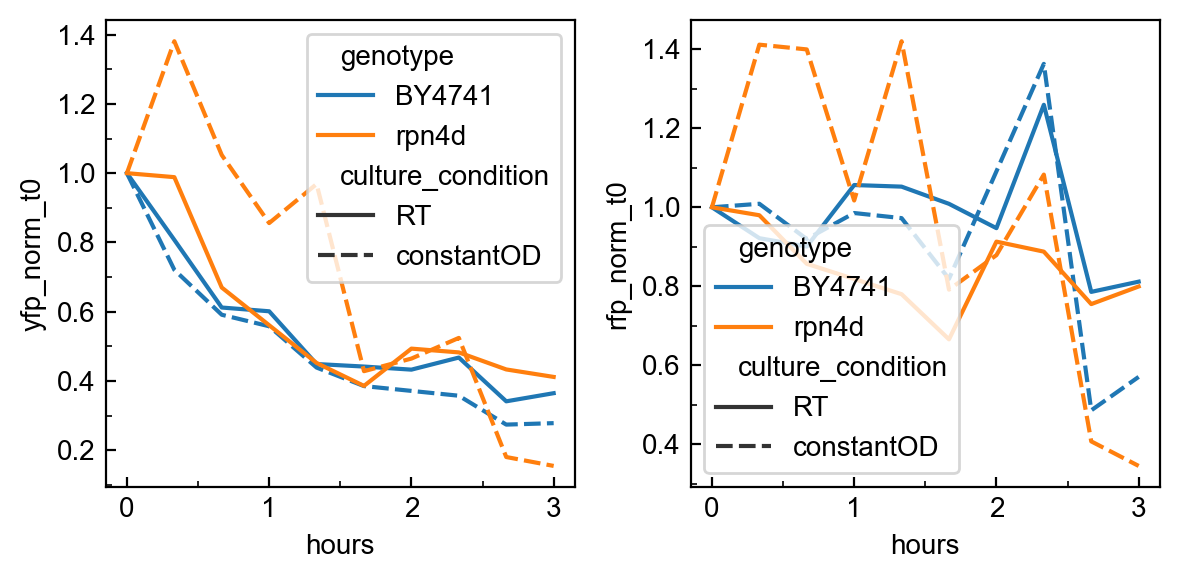

In [305]:
kwargs = {
    'x': 'hours',
    'hue': 'genotype',
    'style': 'culture_condition',
    'data': table[table.rfp_norm_t0>0.2]
}

fig = plt.figure(figsize=(6, 3))
fig.set_dpi(200)
yvars = [
    'yfp_norm_t0',
    'rfp_norm_t0'
]
for i, var in enumerate(yvars):
    ax = fig.add_subplot(1, 2, i +1)
    sns.lineplot(**kwargs, ax=ax, y=var)
    plotting.format_ticks(ax)
plt.tight_layout()

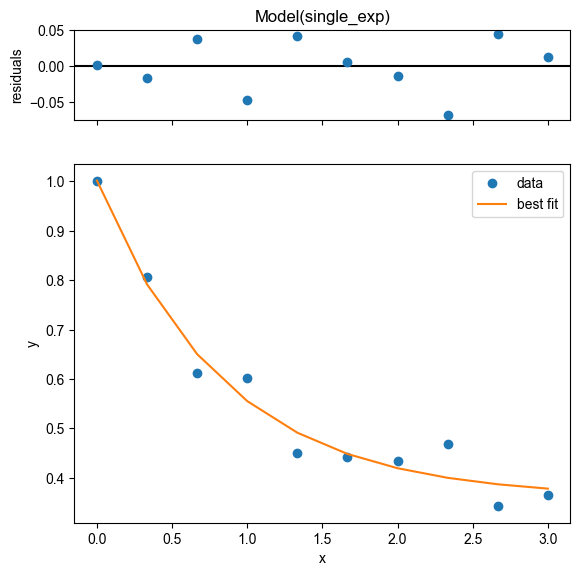

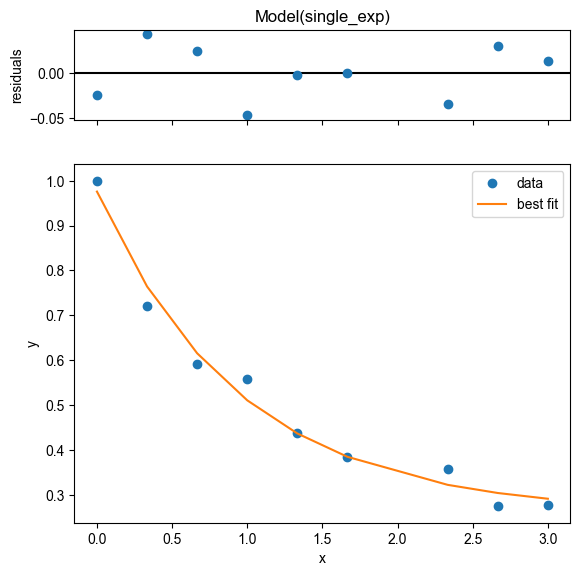

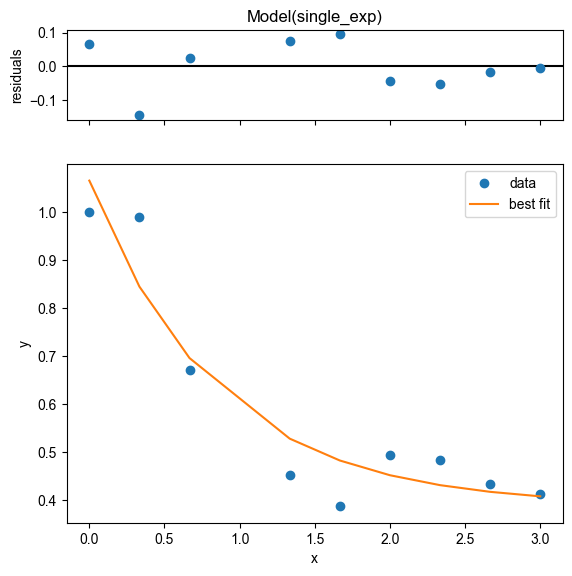

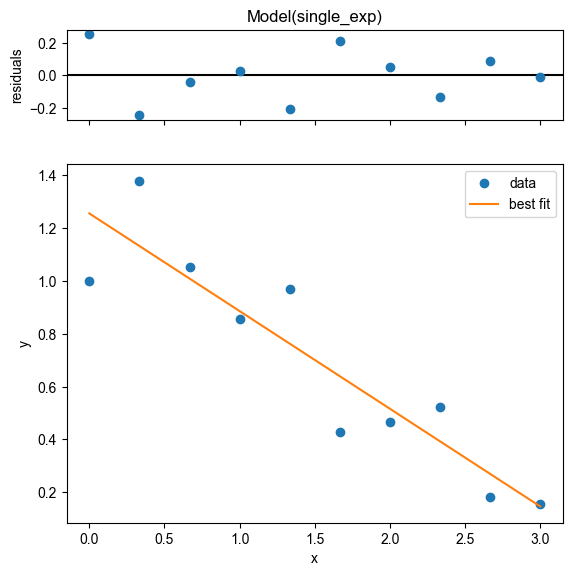

In [312]:
sample_conditions = [
    'genotype',
    'culture_condition'
]

uniques = list(table.set_index(sample_conditions).index.unique())
# Get a list of booldexes that select for unique samples 
# in the master table
booldices = []
for idx in uniques:
    booldex = (table[sample_conditions[0]] == idx[0]) & (table[sample_conditions[1]] == idx[1]) & (table.rfp_norm_t0>0.2)
    booldices.append(booldex)
    
import lmfit

resultdfs = []
for i, booldex in enumerate(booldices):
    result, resultdf = fitting_tools.fit_model_to_df(
        table,
        booldex,
        fitting_tools.model_guesses.exponential[0],
        fitting_tools.model_guesses.exponential[1],
        xvar='hours',
        yvar='yfp_norm_t0',
        label_parent_df=True
    )
    result.plot()
    resultdf.loc[:, sample_conditions[0]] = uniques[i][0]
    resultdf.loc[:, sample_conditions[1]] = uniques[i][1]
    resultdfs.append(resultdf)

In [319]:
resultsdf = pd.concat(resultdfs)
resultsdf.loc[:, ['b', 'culture_condition', 'genotype']]

,b,culture_condition,genotype
0,1.190081,RT,BY4741
0,1.051684,constantOD,BY4741
0,1.184452,RT,rpn4d
0,0.000012,constantOD,rpn4d


### Preliminary BYC data with NLS, VHL, ERmDeg substrates

In [324]:
%%capture database_readin

traces_df, fits_df, buds_df = database.read_in_trace_fits_buds_dfs()
# clean_escape_annotation happens on refresh database
buds_df = database.get_clean_buds_df(buds_df, clean_escape_annotation=False)
survivaldf, table = database.generate_survivaldf(fits_df, buds_df)

from byc import trace_tools

#### NLS-mScarletI-VHL data

Saved figure at
C:\Users\johnp\Dropbox\Projects\byc\data\meta\plots\x=x_input_y=y_input_norm_hue=buds_after_death_strain=JPC112.svg


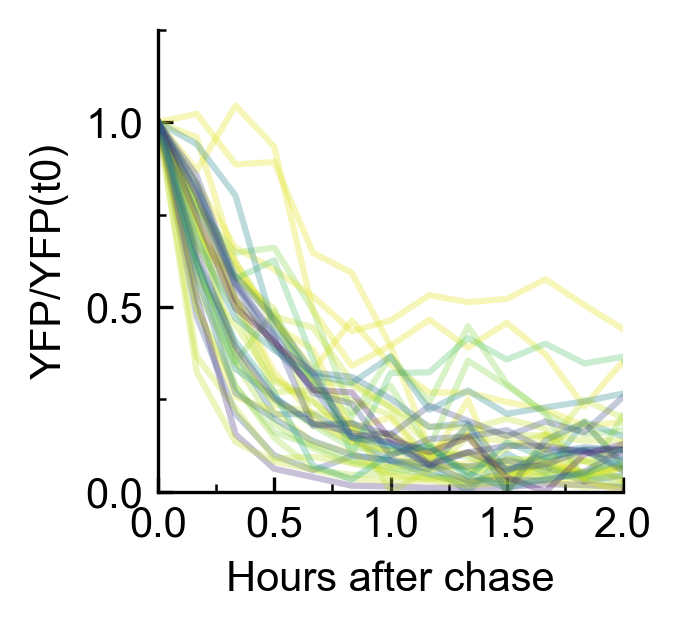

In [375]:
plotting.set_styles(matplotlib, plt)

# strains = ['JPC228', 'JPC258']
# strains = ['JPC263']
# strains = ['JPC122']
# strains = ['JPC121', 'JPC220', 'JPC146']
strains = ['JPC112']

name= '-'.join(strains)
plot_means = False
filename = f'{name}'
sub_traces_df = traces_df[traces_df.strain_name.isin(strains)]
# sub_traces_df = traces_df[traces_df.compartment_name.isin(constants.compartments_dict['wt_ubl'])]

strains = sub_traces_df.strain_name.unique()
# sub_traces_df = sub_traces_df[sub_traces_df.potential_blue_light_exposure_during_filter_cube_switching==False]
sub_traces_df = sub_traces_df[sub_traces_df.dist_from_sen>-1]
sub_traces_df.loc[:, 'measdex'] = sub_traces_df.measdex.str.cat(sub_traces_df.dist_from_sen.astype(str), sep='-')
sub_traces_df.loc[:, 'dist_from_sen_bin'] = '>7'
sub_traces_df.loc[sub_traces_df.dist_from_sen<=7, 'dist_from_sen_bin'] = '<=7'
sub_traces_df.dropna(subset=['dist_from_sen_bin'], inplace=True)
# sub_traces_df = sub_traces_df[~sub_traces_df.compartment_name.isin(skip_comps)]
# Define plotting variables
yvar = 'y_input_norm'
xvar = 'x_input'
huevar = 'buds_after_death'
alpha = 0.3
size =14
fontsize=10
linewidth = 1
xlim = (0, 2)
ylim = (0, 1.25)
ylabel = 'YFP/YFP(t0)'
xlabel = 'Hours after chase'
# Make palette
min_dist_from_sen = int(np.min(sub_traces_df[huevar]))
min_dist_from_sen = -20
max_dist_from_sen = 0
colors = sns.color_palette('viridis_r', max_dist_from_sen - min_dist_from_sen +1)
colors_list = [c for c in colors]
colors_list.reverse()
keys = list(range(min_dist_from_sen, max_dist_from_sen + 1))
palette_dict = dict(zip(keys, colors_list))

wanted = [
    2,
    20
    ]
median_colors = [colors_list[i] for i in wanted]
fig, ax = plotting.figure_ax()
fig.set_dpi(300)
# Subsample so we're not overplotting too much
n_cells_to_sample = 1000
random_seed = 1
if len(sub_traces_df.measdex.unique()) >= n_cells_to_sample:
    measdices_to_plot = np.random.choice(sub_traces_df.measdex.unique(), n_cells_to_sample, replace=False)
else:
    measdices_to_plot = sub_traces_df.measdex.unique()

previous_measdices = []
for measdex in measdices_to_plot:
    # Making sure I don't plot duplicates
    if measdex not in previous_measdices:
        subdf = sub_traces_df.set_index('measdex').loc[measdex, :].reset_index()
        subdf.sort_values(by=xvar, inplace=True, ascending=True)
        bin_name = subdf.loc[0, 'dist_from_sen_bin']
        dist_from_sen = subdf.loc[0, huevar]
        key = int(dist_from_sen)
        if key < min_dist_from_sen:
            key = min_dist_from_sen
        color = palette_dict[key]
        ax.plot(subdf[xvar], subdf[yvar], color=color, alpha=alpha)
    else:
        print(f'Duplicate measurements:\n{measdex}')
    previous_measdices.append(measdex)


linekwargs = {
    'x': xvar,
    'y': yvar,
    'data': subdf,
    'hue': huevar,
    'ax': ax,
    'estimator': 'mean',
    'palette': median_colors,
    'hue_order': sub_traces_df[huevar].unique()
}
if plot_means:
    sns.lineplot(**linekwargs)
    L=ax.legend(title="Buds before death.", frameon=False)
    labels = df[huevar].unique()

    for idx in range(len(labels)):
        L.get_texts()[idx].set_text(labels[idx])


ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.set_yticks(np.arange(0, 1.1, 0.5))
ax.set_xticks(np.arange(0, 2.1, 0.5))

plotting.remove_spines(ax)
plotting.format_ticks(ax)

ax.set_ylabel(ylabel, fontsize=fontsize, color='black')
ax.set_xlabel(xlabel, fontsize=fontsize)

linekwargs['strain'] = strains[0]
plotting.save_figure(fig, linekwargs, ext='.svg')

Saved logistic fit results at
C:\Users\johnp\Dropbox\Projects\byc\data\meta\JPC112_linear-fit_b-vs-dist-from-sen.csv
Saved figure at
C:\Users\johnp\Dropbox\Projects\byc\data\meta\plots\x=dist_from_sen_y=k and cycle duration_strains=JPC112.svg


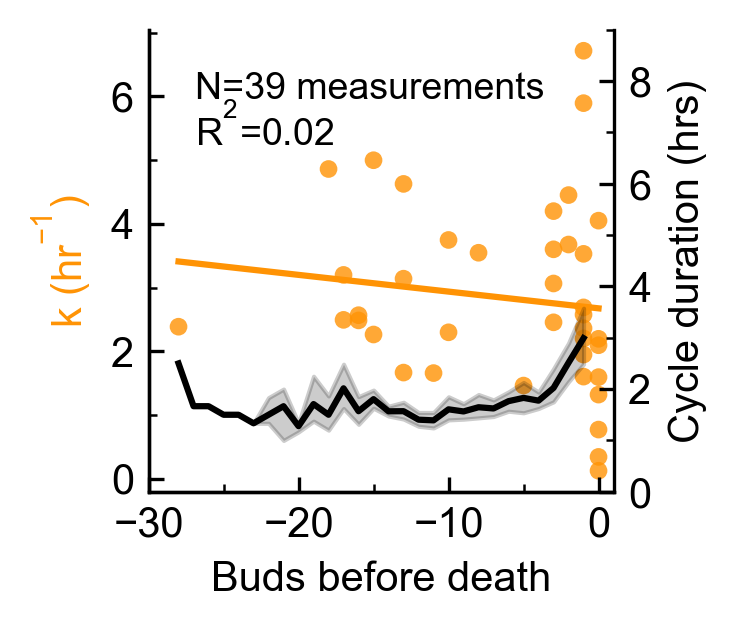

In [374]:
from byc.plotting import strains_color_dict
plotting.set_styles(plt, matplotlib)
reload(fitting_tools)
# strains = ['JPC121', 'JPC146', 'JPC220']
# # strains = ['JPC122']
# # strains = ['JPC258', 'JPC228']
# # strains = ['JPC258_r']
# # strains = ['JPC259']
# # strains = ['JPC199']
# # strains = ['JPC193']
# # strains = ['JPC262']
# # strains = ['JPC136']
# # strains = ['JPC274']
skip_comps = [
]
comps_list = fits_df[fits_df.strain_name=='JPC112'].compartment_name.unique()
sub_fits_df = fits_df[fits_df.compartment_name.isin(comps_list)]
sub_fits_df = sub_fits_df[~sub_fits_df.b.isna()]
sub_bud_df = buds_df[buds_df.compartment_name.isin(comps_list)]

# ratecolor = strains_color_dict[sub_fits_df.strain_name.unique()[0]]
ratecolor = strains_color_dict['JPC121']
# ratecolor= matplotlib.colors.to_rgb('purple')
# ratecolor = (255/255,20/255,147/255)
postsep_border = -5
fit_type = 'line'
xlim = (-30, 1)
ylim = (0, 2)
shade_stderr = False
fillalpha = 0.25
fillsep = False
daughter_shape='All'
fig, ax = plotting.figure_ax(width_scale=1)
fig.set_dpi(300)
yvar1 = 'b'
yvar2 = 'cycle_duration_hrs'
xvar = 'buds_after_death'
alpha = 0.8
size = 15
fontsize=10
ylabel1 = 'Cycle duration (hrs)'
ylabel2 = 'k (hr$^{-1}$)'
xlabel = 'Buds before death'
if fillsep:
    # Shade post-SEP area
    xfill = np.arange(postsep_border, 1.5, 0.5)
    ax.fill_between(
        xfill,
        np.full(len(xfill), np.max(ylim)),
        color=pre_post_SEP_palette[1],
        alpha=fillalpha,
        edgecolor=None)
    # Shade pre-SEP area
    xfill = np.arange(np.min(xlim) - 0.5, postsep_border - 0.5, 0.5)
    ax.fill_between(
        xfill,
        np.full(len(xfill), np.max(ylim)),
        color=pre_post_SEP_palette[0],
        alpha=fillalpha,
        edgecolor=None)

if fit_type=='logistic':
    # fit to logistic
        fitsdf, smoothdf, result = fitting_tools.fit_logistic_to_fits_df(sub_fits_df, return_result=True)
        kernsize = 3
        trace_tools.mean_filter(
            smoothdf,
            'stderr',
            kernsize,
            name_with_kernel=True)  

        params = (fitsdf.L.iloc[0], fitsdf.k.iloc[0], fitsdf.x_center.iloc[0], fitsdf.offset.iloc[0])
        x = np.sort(sub_fits_df[xvar].unique())
        x = np.arange(-10, 40, 1)
        y_pred = fitting_tools.logistic(x, *params)
        ax.plot(x, y_pred, color=ratecolor)
        
elif fit_type=='exponential':
    # fit to logistic
        result, results_df = fitting_tools.fit_model_to_df(sub_fits_df, ~sub_fits_df.b.isna(),
                                                           fitting_tools.model_guesses.exponential_turn_down[0],
                                                           fitting_tools.model_guesses.exponential_turn_down[1]
                                                          )
        x = np.sort(sub_fits_df[xvar].unique())
        y_pred = result.model.eval(params=result.params, x=x)
        ax.plot(x, y_pred, color=ratecolor)
        
elif fit_type=='piecewise':
    # fit to logistic
        result, results_df = fitting_tools.fit_model_to_df(sub_fits_df, ~sub_fits_df.b.isna(),
                                                           fitting_tools.model_guesses.piecewise_linear[0],
                                                           fitting_tools.model_guesses.piecewise_linear[1]
                                                          )
        x = np.sort(sub_fits_df[xvar].unique())
        y_pred = result.model.eval(params=result.params, x=x)
        ax.plot(x, y_pred, color=ratecolor)

elif fit_type=='line':
    # Fit to line
    fitsdf, smoothdf, result = fitting_tools.fit_line_to_fits_df(sub_fits_df, return_result=True)
    kernsize = 3
    trace_tools.mean_filter(
        smoothdf,
        'stderr',
        kernsize,
        name_with_kernel=True)  
    x = np.sort(sub_fits_df['dist_from_sen'].unique())
    params = (fitsdf.m.iloc[0], fitsdf.b.iloc[0])
    y_pred = fitting_tools.line(x, *params)
    x = 0 - x
    ax.plot(x, y_pred, color=ratecolor)

elif fit_type=='median':
     
    sns.lineplot(x=xvar, y=yvar1, data=sub_fits_df, ax=ax, color=ratecolor, estimator='median')
    # Get stats for 
    x = sub_fits_df.sort_values(by='dist_from_sen', ascending=True)[xvar].unique()
    y_pred = sub_fits_df.sort_values(by='dist_from_sen', ascending=True).loc[:, [xvar, yvar1]].pivot_table(index=[xvar], aggfunc='median').values
    y_pred = np.reshape(y_pred, len(y_pred))

else:
    print(f'No fit type <{fit_type}>. Please use either logistic or line')
# Derive statistics of fit
r_sq, ydata, ypred = fitting_tools.get_r_sq_with_multi_y_per_x(x, y_pred, sub_fits_df, return_new_y_ypreds=True, xvar=xvar)
n = len(sub_fits_df)
# Shade standard error of the mean for 
if shade_stderr:
    xvar_fill = 'x_input_smooth'
    yvar_fill = 'y_pred'
    errvar = f'stderr'
    # errvar = f'stderr'

    err_kwargs = {
        'x': smoothdf[xvar_fill],
        'y1': smoothdf[yvar_fill] + smoothdf[errvar],
        'y2': smoothdf[yvar_fill] - smoothdf[errvar]
    }

    kwargs = {
        'x': xvar_fill,
        'y': 'y_pred',
        'data': smoothdf,
        'err_kws': err_kwargs
    }
    ax.fill_between(
        err_kwargs['x'],
        err_kwargs['y1'],
        err_kwargs['y2'],
        color=ratecolor,
        alpha=0.2
        )
# Format axes
ax.set_xlim(xlim)
ax.set_xlabel(xlabel, fontsize=fontsize)
ax.set_xticks(np.arange(xlim[0], 1, 10))
# ax.set_ylim(ylim)
# ax.set_yticks(np.arange(0, ylim[1]+0.1, 1))
ax2 = ax.twinx()
ax2.set_ylim(0, 9)
# ax2.set_yticks(np.arange(0, ylim[1]+0.1, 1))
# plot cycle durations
sns.lineplot(x=xvar, y=yvar2, data=sub_bud_df,ax=ax2, color='black')
# Plot rate constants
kwargs = {
    'x': xvar,
    'y': yvar1,
    'alpha': alpha,
    'data': sub_fits_df,
    'ax': ax,
    'size': size,
    'color': ratecolor,
    'linewidth': 0,
    'edgecolor': ratecolor + (0,) #The (0, ) tuple adds alpha to the ratecolor tuple
}
sns.scatterplot(**kwargs)
ax.legend_.set_visible(False)
# Aesthetics
plotting.remove_spines(ax)
plotting.format_ticks(ax)
plotting.format_ticks(ax2)
ax2.spines['top'].set_visible(False)

ax2.set_ylabel(ylabel1, fontsize=fontsize)
ax.set_ylabel(ylabel2, color=ratecolor, fontsize=fontsize)

# Annotate stats
xy_n = (0.1, 0.85)
xy_rsq = (0.1, 0.75)
rsq_str = f'{plotting.annoying_strings().r_sq}={np.round(r_sq, 2)}'
n_str = f'N={np.round(n, 2)} measurements'
if fit_type == 'median':
    pass
    # ax.annotate(rsq_str, xy_rsq, fontsize=fontsize-1)
else:
    ax.annotate(rsq_str, xy_rsq, fontsize=fontsize-1, xycoords='axes fraction')
ax.annotate(n_str, xy_n, fontsize=fontsize-1, xycoords='axes fraction')
strains = sub_fits_df.strain_name.unique()                                     
kwargs = {
    'x': 'dist_from_sen',
    'y': 'k and cycle duration',
    'strains': '-'.join(strains)
}
# sns.lineplot(x=xvar, y=yvar1, data=sub_fits_df, ax=ax, color=ratecolor, estimator='median')
plotting.save_figure(fig, kwargs, ext='.svg')

#### Bar-YFP-ERmDeg data

Saved logistic fit results at
C:\Users\johnp\Dropbox\Projects\byc\data\meta\JPC107_linear-fit_b-vs-dist-from-sen.csv
Saved figure at
C:\Users\johnp\Dropbox\Projects\byc\data\meta\plots\x=dist_from_sen_y=k and cycle duration_strains=JPC107.svg


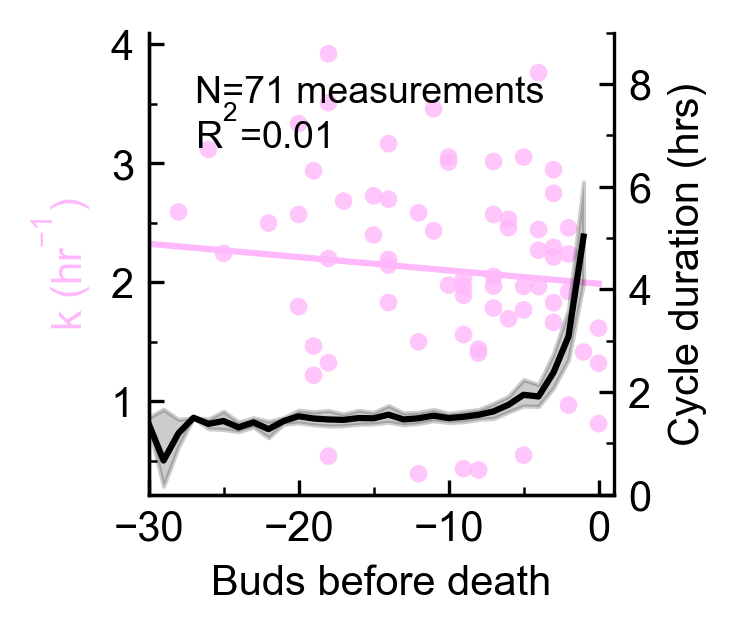

In [366]:
whole_cell_color = "#FFB8FB"
aggregate_color  = "#68EDEB"

plotting.set_styles(plt, matplotlib)
reload(fitting_tools)
# strains = ['JPC121', 'JPC146', 'JPC220']
# # strains = ['JPC122']
# # strains = ['JPC258', 'JPC228']
# # strains = ['JPC258_r']
# # strains = ['JPC259']
# # strains = ['JPC199']
# # strains = ['JPC193']
# # strains = ['JPC262']
# # strains = ['JPC136']
# # strains = ['JPC274']
skip_comps = [
]
comps_list = fits_df[fits_df.strain_name=='JPC107'].compartment_name.unique()
sub_fits_df = fits_df[fits_df.compartment_name.isin(comps_list)]
sub_fits_df = sub_fits_df[~sub_fits_df.b.isna()]
sub_bud_df = buds_df[buds_df.compartment_name.isin(comps_list)]

# ratecolor = strains_color_dict[sub_fits_df.strain_name.unique()[0]]
ratecolor= matplotlib.colors.to_rgb(whole_cell_color)
# ratecolor = (255/255,20/255,147/255)
postsep_border = -5
fit_type = 'line'
xlim = (-30, 1)
ylim = (0, 2)
shade_stderr = False
fillalpha = 0.25
fillsep = False
daughter_shape='All'
fig, ax = plotting.figure_ax(width_scale=1)
fig.set_dpi(300)
yvar1 = 'b'
yvar2 = 'cycle_duration_hrs'
xvar = 'buds_after_death'
alpha = 0.8
size = 15
fontsize=10
ylabel1 = 'Cycle duration (hrs)'
ylabel2 = 'k (hr$^{-1}$)'
xlabel = 'Buds before death'
if fillsep:
    # Shade post-SEP area
    xfill = np.arange(postsep_border, 1.5, 0.5)
    ax.fill_between(
        xfill,
        np.full(len(xfill), np.max(ylim)),
        color=pre_post_SEP_palette[1],
        alpha=fillalpha,
        edgecolor=None)
    # Shade pre-SEP area
    xfill = np.arange(np.min(xlim) - 0.5, postsep_border - 0.5, 0.5)
    ax.fill_between(
        xfill,
        np.full(len(xfill), np.max(ylim)),
        color=pre_post_SEP_palette[0],
        alpha=fillalpha,
        edgecolor=None)

if fit_type=='logistic':
    # fit to logistic
        fitsdf, smoothdf, result = fitting_tools.fit_logistic_to_fits_df(sub_fits_df, return_result=True)
        kernsize = 3
        trace_tools.mean_filter(
            smoothdf,
            'stderr',
            kernsize,
            name_with_kernel=True)  

        params = (fitsdf.L.iloc[0], fitsdf.k.iloc[0], fitsdf.x_center.iloc[0], fitsdf.offset.iloc[0])
        x = np.sort(sub_fits_df[xvar].unique())
        x = np.arange(-10, 40, 1)
        y_pred = fitting_tools.logistic(x, *params)
        ax.plot(x, y_pred, color=ratecolor)
        
elif fit_type=='exponential':
    # fit to logistic
        result, results_df = fitting_tools.fit_model_to_df(sub_fits_df, ~sub_fits_df.b.isna(),
                                                           fitting_tools.model_guesses.exponential_turn_down[0],
                                                           fitting_tools.model_guesses.exponential_turn_down[1]
                                                          )
        x = np.sort(sub_fits_df[xvar].unique())
        y_pred = result.model.eval(params=result.params, x=x)
        ax.plot(x, y_pred, color=ratecolor)
        
elif fit_type=='piecewise':
    # fit to logistic
        result, results_df = fitting_tools.fit_model_to_df(sub_fits_df, ~sub_fits_df.b.isna(),
                                                           fitting_tools.model_guesses.piecewise_linear[0],
                                                           fitting_tools.model_guesses.piecewise_linear[1]
                                                          )
        x = np.sort(sub_fits_df[xvar].unique())
        y_pred = result.model.eval(params=result.params, x=x)
        ax.plot(x, y_pred, color=ratecolor)

elif fit_type=='line':
    # Fit to line
    fitsdf, smoothdf, result = fitting_tools.fit_line_to_fits_df(sub_fits_df, return_result=True)
    kernsize = 3
    trace_tools.mean_filter(
        smoothdf,
        'stderr',
        kernsize,
        name_with_kernel=True)  
    x = np.sort(sub_fits_df['dist_from_sen'].unique())
    params = (fitsdf.m.iloc[0], fitsdf.b.iloc[0])
    y_pred = fitting_tools.line(x, *params)
    x = 0 - x
    ax.plot(x, y_pred, color=ratecolor)

elif fit_type=='median':
     
    sns.lineplot(x=xvar, y=yvar1, data=sub_fits_df, ax=ax, color=ratecolor, estimator='median')
    # Get stats for 
    x = sub_fits_df.sort_values(by='dist_from_sen', ascending=True)[xvar].unique()
    y_pred = sub_fits_df.sort_values(by='dist_from_sen', ascending=True).loc[:, [xvar, yvar1]].pivot_table(index=[xvar], aggfunc='median').values
    y_pred = np.reshape(y_pred, len(y_pred))

else:
    print(f'No fit type <{fit_type}>. Please use either logistic or line')
# Derive statistics of fit
r_sq, ydata, ypred = fitting_tools.get_r_sq_with_multi_y_per_x(x, y_pred, sub_fits_df, return_new_y_ypreds=True, xvar=xvar)
n = len(sub_fits_df)
# Shade standard error of the mean for 
if shade_stderr:
    xvar_fill = 'x_input_smooth'
    yvar_fill = 'y_pred'
    errvar = f'stderr'
    # errvar = f'stderr'

    err_kwargs = {
        'x': smoothdf[xvar_fill],
        'y1': smoothdf[yvar_fill] + smoothdf[errvar],
        'y2': smoothdf[yvar_fill] - smoothdf[errvar]
    }

    kwargs = {
        'x': xvar_fill,
        'y': 'y_pred',
        'data': smoothdf,
        'err_kws': err_kwargs
    }
    ax.fill_between(
        err_kwargs['x'],
        err_kwargs['y1'],
        err_kwargs['y2'],
        color=ratecolor,
        alpha=0.2
        )
# Format axes
ax.set_xlim(xlim)
ax.set_xlabel(xlabel, fontsize=fontsize)
ax.set_xticks(np.arange(xlim[0], 1, 10))
# ax.set_ylim(ylim)
# ax.set_yticks(np.arange(0, ylim[1]+0.1, 1))
ax2 = ax.twinx()
ax2.set_ylim(0, 9)
# ax2.set_yticks(np.arange(0, ylim[1]+0.1, 1))
# plot cycle durations
sns.lineplot(x=xvar, y=yvar2, data=sub_bud_df,ax=ax2, color='black')
# Plot rate constants
kwargs = {
    'x': xvar,
    'y': yvar1,
    'alpha': alpha,
    'data': sub_fits_df,
    'ax': ax,
    'size': size,
    'color': ratecolor,
    'linewidth': 0,
    'edgecolor': ratecolor + (0,) #The (0, ) tuple adds alpha to the ratecolor tuple
}
sns.scatterplot(**kwargs)
ax.legend_.set_visible(False)
# Aesthetics
plotting.remove_spines(ax)
plotting.format_ticks(ax)
plotting.format_ticks(ax2)
ax2.spines['top'].set_visible(False)

ax2.set_ylabel(ylabel1, fontsize=fontsize)
ax.set_ylabel(ylabel2, color=ratecolor, fontsize=fontsize)

# Annotate stats
xy_n = (0.1, 0.85)
xy_rsq = (0.1, 0.75)
rsq_str = f'{plotting.annoying_strings().r_sq}={np.round(r_sq, 2)}'
n_str = f'N={np.round(n, 2)} measurements'
if fit_type == 'median':
    pass
    # ax.annotate(rsq_str, xy_rsq, fontsize=fontsize-1)
else:
    ax.annotate(rsq_str, xy_rsq, fontsize=fontsize-1, xycoords='axes fraction')
ax.annotate(n_str, xy_n, fontsize=fontsize-1, xycoords='axes fraction')
strains = sub_fits_df.strain_name.unique()                                     
kwargs = {
    'x': 'dist_from_sen',
    'y': 'k and cycle duration',
    'strains': '-'.join(strains)
}
# sns.lineplot(x=xvar, y=yvar1, data=sub_fits_df, ax=ax, color=ratecolor, estimator='median')
plotting.save_figure(fig, kwargs, ext='.svg')

Saved logistic fit results at
C:\Users\johnp\Dropbox\Projects\byc\data\meta\JPC107_agg_linear-fit_b-vs-dist-from-sen.csv
Saved figure at
C:\Users\johnp\Dropbox\Projects\byc\data\meta\plots\x=dist_from_sen_y=k and cycle duration_strains=JPC107_agg.svg


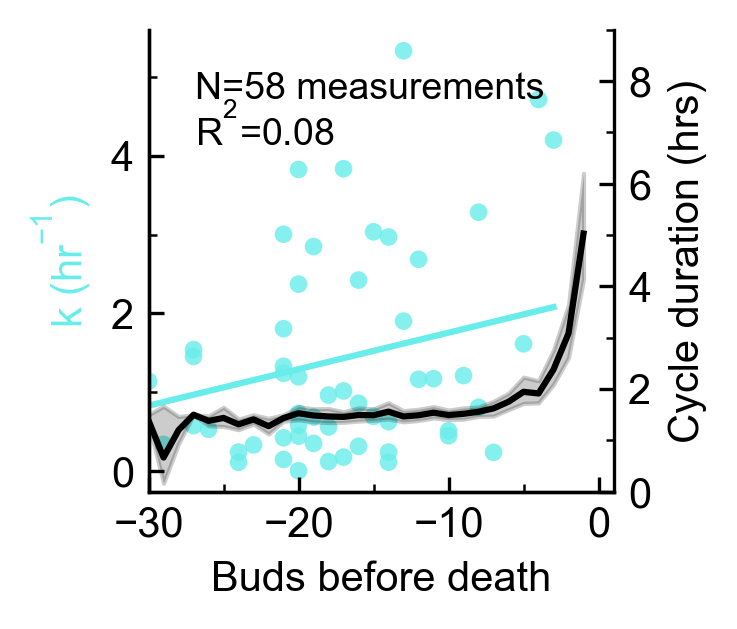

In [368]:
whole_cell_color = "#FFB8FB"
aggregate_color  = "#68EDEB"

plotting.set_styles(plt, matplotlib)
reload(fitting_tools)
# strains = ['JPC121', 'JPC146', 'JPC220']
# # strains = ['JPC122']
# # strains = ['JPC258', 'JPC228']
# # strains = ['JPC258_r']
# # strains = ['JPC259']
# # strains = ['JPC199']
# # strains = ['JPC193']
# # strains = ['JPC262']
# # strains = ['JPC136']
# # strains = ['JPC274']
skip_comps = [
]
comps_list = fits_df[fits_df.strain_name=='JPC107_agg'].compartment_name.unique()
sub_fits_df = fits_df[fits_df.compartment_name.isin(comps_list)]
sub_fits_df = sub_fits_df[~sub_fits_df.b.isna()]
sub_bud_df = buds_df[buds_df.compartment_name.isin(fits_df[fits_df.strain_name=='JPC107'].compartment_name.unique())]

# ratecolor = strains_color_dict[sub_fits_df.strain_name.unique()[0]]
ratecolor= matplotlib.colors.to_rgb(aggregate_color)
# ratecolor = (255/255,20/255,147/255)
postsep_border = -5
fit_type = 'line'
xlim = (-30, 1)
ylim = (0, 2)
shade_stderr = False
fillalpha = 0.25
fillsep = False
daughter_shape='All'
fig, ax = plotting.figure_ax(width_scale=1)
fig.set_dpi(300)
yvar1 = 'b'
yvar2 = 'cycle_duration_hrs'
xvar = 'buds_after_death'
alpha = 0.8
size = 15
fontsize=10
ylabel1 = 'Cycle duration (hrs)'
ylabel2 = 'k (hr$^{-1}$)'
xlabel = 'Buds before death'
if fillsep:
    # Shade post-SEP area
    xfill = np.arange(postsep_border, 1.5, 0.5)
    ax.fill_between(
        xfill,
        np.full(len(xfill), np.max(ylim)),
        color=pre_post_SEP_palette[1],
        alpha=fillalpha,
        edgecolor=None)
    # Shade pre-SEP area
    xfill = np.arange(np.min(xlim) - 0.5, postsep_border - 0.5, 0.5)
    ax.fill_between(
        xfill,
        np.full(len(xfill), np.max(ylim)),
        color=pre_post_SEP_palette[0],
        alpha=fillalpha,
        edgecolor=None)

if fit_type=='logistic':
    # fit to logistic
        fitsdf, smoothdf, result = fitting_tools.fit_logistic_to_fits_df(sub_fits_df, return_result=True)
        kernsize = 3
        trace_tools.mean_filter(
            smoothdf,
            'stderr',
            kernsize,
            name_with_kernel=True)  

        params = (fitsdf.L.iloc[0], fitsdf.k.iloc[0], fitsdf.x_center.iloc[0], fitsdf.offset.iloc[0])
        x = np.sort(sub_fits_df[xvar].unique())
        x = np.arange(-10, 40, 1)
        y_pred = fitting_tools.logistic(x, *params)
        ax.plot(x, y_pred, color=ratecolor)
        
elif fit_type=='exponential':
    # fit to logistic
        result, results_df = fitting_tools.fit_model_to_df(sub_fits_df, ~sub_fits_df.b.isna(),
                                                           fitting_tools.model_guesses.exponential_turn_down[0],
                                                           fitting_tools.model_guesses.exponential_turn_down[1]
                                                          )
        x = np.sort(sub_fits_df[xvar].unique())
        y_pred = result.model.eval(params=result.params, x=x)
        ax.plot(x, y_pred, color=ratecolor)
        
elif fit_type=='piecewise':
    # fit to logistic
        result, results_df = fitting_tools.fit_model_to_df(sub_fits_df, ~sub_fits_df.b.isna(),
                                                           fitting_tools.model_guesses.piecewise_linear[0],
                                                           fitting_tools.model_guesses.piecewise_linear[1]
                                                          )
        x = np.sort(sub_fits_df[xvar].unique())
        y_pred = result.model.eval(params=result.params, x=x)
        ax.plot(x, y_pred, color=ratecolor)

elif fit_type=='line':
    # Fit to line
    fitsdf, smoothdf, result = fitting_tools.fit_line_to_fits_df(sub_fits_df, return_result=True)
    kernsize = 3
    trace_tools.mean_filter(
        smoothdf,
        'stderr',
        kernsize,
        name_with_kernel=True)  
    x = np.sort(sub_fits_df['dist_from_sen'].unique())
    params = (fitsdf.m.iloc[0], fitsdf.b.iloc[0])
    y_pred = fitting_tools.line(x, *params)
    x = 0 - x
    ax.plot(x, y_pred, color=ratecolor)

elif fit_type=='median':
     
    sns.lineplot(x=xvar, y=yvar1, data=sub_fits_df, ax=ax, color=ratecolor, estimator='median')
    # Get stats for 
    x = sub_fits_df.sort_values(by='dist_from_sen', ascending=True)[xvar].unique()
    y_pred = sub_fits_df.sort_values(by='dist_from_sen', ascending=True).loc[:, [xvar, yvar1]].pivot_table(index=[xvar], aggfunc='median').values
    y_pred = np.reshape(y_pred, len(y_pred))

else:
    print(f'No fit type <{fit_type}>. Please use either logistic or line')
# Derive statistics of fit
r_sq, ydata, ypred = fitting_tools.get_r_sq_with_multi_y_per_x(x, y_pred, sub_fits_df, return_new_y_ypreds=True, xvar=xvar)
n = len(sub_fits_df)
# Shade standard error of the mean for 
if shade_stderr:
    xvar_fill = 'x_input_smooth'
    yvar_fill = 'y_pred'
    errvar = f'stderr'
    # errvar = f'stderr'

    err_kwargs = {
        'x': smoothdf[xvar_fill],
        'y1': smoothdf[yvar_fill] + smoothdf[errvar],
        'y2': smoothdf[yvar_fill] - smoothdf[errvar]
    }

    kwargs = {
        'x': xvar_fill,
        'y': 'y_pred',
        'data': smoothdf,
        'err_kws': err_kwargs
    }
    ax.fill_between(
        err_kwargs['x'],
        err_kwargs['y1'],
        err_kwargs['y2'],
        color=ratecolor,
        alpha=0.2
        )
# Format axes
ax.set_xlim(xlim)
ax.set_xlabel(xlabel, fontsize=fontsize)
ax.set_xticks(np.arange(xlim[0], 1, 10))
# ax.set_ylim(ylim)
# ax.set_yticks(np.arange(0, ylim[1]+0.1, 1))
ax2 = ax.twinx()
ax2.set_ylim(0, 9)
# ax2.set_yticks(np.arange(0, ylim[1]+0.1, 1))
# plot cycle durations
sns.lineplot(x=xvar, y=yvar2, data=sub_bud_df,ax=ax2, color='black')
# Plot rate constants
kwargs = {
    'x': xvar,
    'y': yvar1,
    'alpha': alpha,
    'data': sub_fits_df,
    'ax': ax,
    'size': size,
    'color': ratecolor,
    'linewidth': 0,
    'edgecolor': ratecolor + (0,) #The (0, ) tuple adds alpha to the ratecolor tuple
}
sns.scatterplot(**kwargs)
ax.legend_.set_visible(False)
# Aesthetics
plotting.remove_spines(ax)
plotting.format_ticks(ax)
plotting.format_ticks(ax2)
ax2.spines['top'].set_visible(False)

ax2.set_ylabel(ylabel1, fontsize=fontsize)
ax.set_ylabel(ylabel2, color=ratecolor, fontsize=fontsize)

# Annotate stats
xy_n = (0.1, 0.85)
xy_rsq = (0.1, 0.75)
rsq_str = f'{plotting.annoying_strings().r_sq}={np.round(r_sq, 2)}'
n_str = f'N={np.round(n, 2)} measurements'
if fit_type == 'median':
    pass
    # ax.annotate(rsq_str, xy_rsq, fontsize=fontsize-1)
else:
    ax.annotate(rsq_str, xy_rsq, fontsize=fontsize-1, xycoords='axes fraction')
ax.annotate(n_str, xy_n, fontsize=fontsize-1, xycoords='axes fraction')
strains = sub_fits_df.strain_name.unique()                                     
kwargs = {
    'x': 'dist_from_sen',
    'y': 'k and cycle duration',
    'strains': '-'.join(strains)
}
# sns.lineplot(x=xvar, y=yvar1, data=sub_fits_df, ax=ax, color=ratecolor, estimator='median')
plotting.save_figure(fig, kwargs, ext='.svg')

## BYC workflow overview

### Representative fluorescence trace

Saved figure at
C:\Users\johnp\Dropbox\Projects\byc\data\meta\plots\x=hours_y=mean_intensity_hue=channel.svg


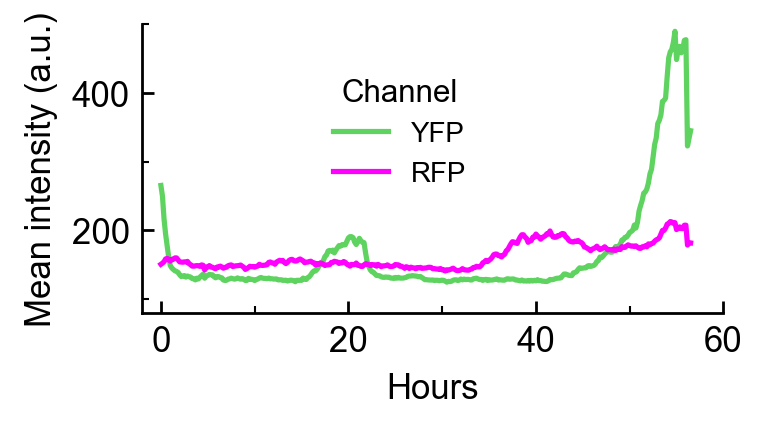

In [26]:
# Read in data
compname = "20221201_byc_JPC220_R-YFP-Su9_HSP104-mCherry_full-traces"
exptname = compname[0:12]
compdir = files.get_byc_compartmentdir(exptname, compname)
alldf = pd.read_csv(os.path.join(compdir, f'{exptname}_alldf.csv'))
alldf.loc[:, 'hours'] = alldf.frame_number*10/60
alldf.loc[:, 'rfp_mean'] = alldf.rfp_mean - alldf.yfp_mean*0.04
alldf_melt = pd.melt(
    alldf,
    id_vars=['frame', 'hours', 'cell_index'],
    value_vars=['yfp_mean', 'rfp_mean'],
    var_name='channel',
    value_name='mean_intensity'
)
# Make figure
fig, ax = plotting.figure_ax(width_scale=1.5, height_scale=0.75)
kwargs = {
    'x': 'hours',
    'y': 'mean_intensity',
    'hue': 'channel',
    'ax': ax,
    'data': alldf_melt[alldf_melt.cell_index==40],
    'palette': [plotting.other_colors['gfp'], plotting.other_colors['dsred']],
    'hue_order': ['yfp_mean', 'rfp_mean']
}

sns.lineplot(**kwargs)

ax.set_xlabel('Hours')
ax.set_ylabel('Mean intensity (a.u.)')
ax.set_xlim(-2, 60)
ax.set_ylim(80, 500)

plotting.format_ticks(ax)
legend = ax.legend(
    ax.get_legend_handles_labels()[0],
    ['YFP', 'RFP'],
    title='Channel',
    frameon=False,
    fontsize=8,
    bbox_to_anchor=(0.6, 0.9)
)
plt.setp(legend.get_title(),fontsize=9)

plotting.save_figure(fig, kwargs, ext='.svg')

### Representative exponential decay

In [320]:
%%capture database_readin

traces_df, fits_df, buds_df = database.read_in_trace_fits_buds_dfs()
# clean_escape_annotation happens on refresh database
buds_df = database.get_clean_buds_df(buds_df, clean_escape_annotation=False)
survivaldf, table = database.generate_survivaldf(fits_df, buds_df)

Saved figure at
C:\Users\johnp\Dropbox\Projects\byc\data\meta\plots\x=x_input_y=y_input_norm_color=(0.37254901960784315, 0.8274509803921568, 0.37254901960784315).svg


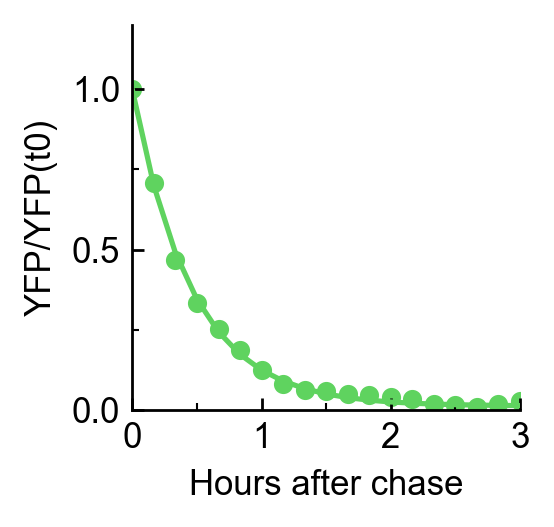

In [48]:
fig, ax = plotting.figure_ax()
compbool = trace_df.compartment_name=='20221201_byc_JPC220_R-YFP-Su9_HSP104-mCherry'
cellbool = compbool&(trace_df.cell_index==92)

kwargs = {
    'x': 'x_input',
    'y': 'y_input_norm',
    'ax': ax,
    'data': trace_df[cellbool],
    'color': plotting.other_colors['gfp']
}

linekwargs = {
    'x': kwargs['x'],
    'y': 'y_pred_norm',
    'ax': kwargs['ax'],
    'data': kwargs['data'],
    'color': kwargs['color']
}

sns.scatterplot(**kwargs)
sns.lineplot(**linekwargs)

ax.set_xlim(0, 3)
ax.set_ylim(0, 1.2)
ax.set_yticks(np.arange(0, 1.25, 0.5))
ax.set_ylabel('YFP/YFP(t0)')
ax.set_xlabel('Hours after chase')

plotting.format_ticks(ax)

plotting.save_figure(fig, kwargs, ext='.svg')

### Representative survival curve

In [54]:
survivaldf[survivaldf.strain_name=='JPC258'].compartment_name.unique()

array(['20230201_byc_JPC228-20230127-int_UBL-YFP-Su9x3_BY4741'],
      dtype=object)

Saved figure at
C:\Users\johnp\Dropbox\Projects\byc\data\meta\plots\x=x_kmf_y=y_kmf_color=black.svg


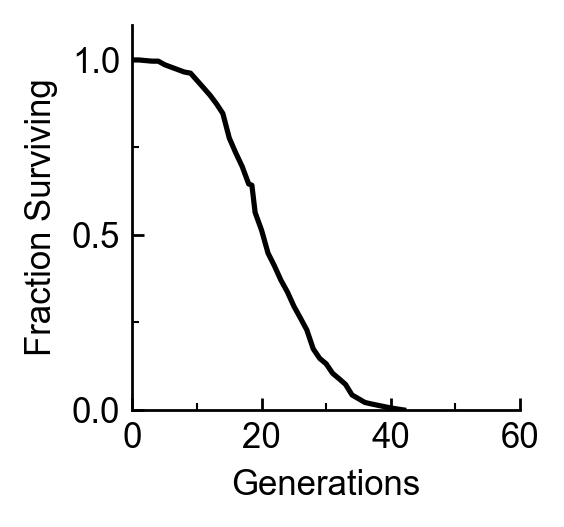

In [62]:
compbool = survivaldf.compartment_name=='20230201_byc_JPC228-20230127-int_UBL-YFP-Su9x3_BY4741'
fig, ax = plotting.figure_ax()

kwargs = {
    'x': 'x_kmf',
    'y': 'y_kmf',
    'ax': ax,
    'color': 'black',
    'data': survivaldf[compbool]
}

sns.lineplot(**kwargs)

ax.set_xlim(0, 60)
ax.set_ylim(0, 1.1)
ax.set_yticks([0, 0.5, 1])
plotting.format_ticks(ax)
ax.set_xlabel('Generations')
ax.set_ylabel('Fraction Surviving')
plotting.save_figure(fig, kwargs, ext='.svg')

## Alignment

### Plot representative x and y translational offsets

Saved figure at
C:\Users\johnp\Dropbox\Projects\byc\data\meta\plots\x=Hours_y=Offset_hue=Dimension_linewidth=1.svg


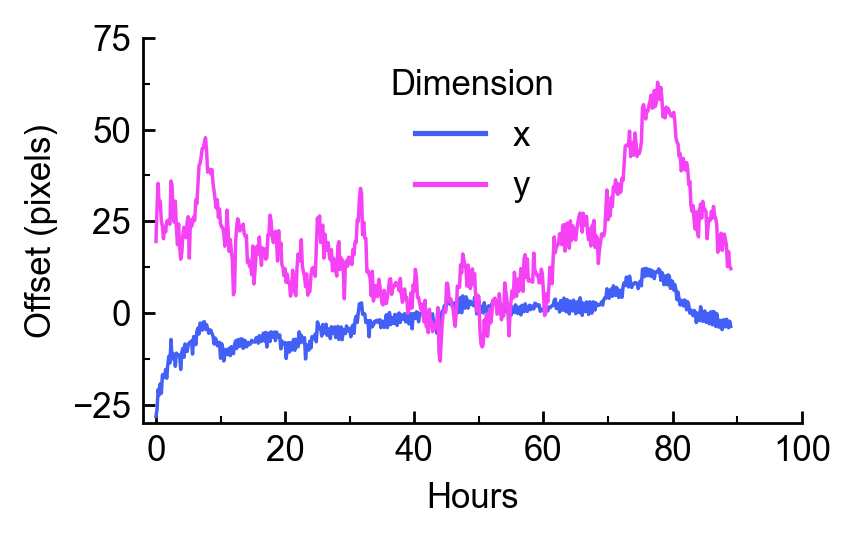

In [66]:
exptname = '20230928_byc'
exptdir = os.path.join(constants.byc_data_dir, exptname)
offsetdf = pd.read_csv(os.path.join(exptdir, 'offsets.csv'))
offsetdf_melt = pd.melt(
    offsetdf,
    id_vars=['frame'],
    value_vars=['x_offset', 'y_offset'],
    var_name='Dimension',
    value_name='Offset'
)
offsetdf_melt.loc[:, 'Hours'] = offsetdf_melt.frame*10/60
fig, ax = plotting.figure_ax(width_scale=1.7)
kwargs = {
    'x': 'Hours',
    'y': 'Offset',
    'hue': 'Dimension',
    'ax': ax,
    'data': offsetdf_melt,
    'palette': ['#4260f5', '#f542f5'],
    'linewidth': 1
}

# sns.scatterplot(**kwargs)
sns.lineplot(**kwargs)
ax.set_ylabel('Offset (pixels)')
ax.set_xlim(-2, 100)
ax.set_ylim(-30, 75)
plotting.format_ticks(ax)
ax.legend(
    ax.get_legend_handles_labels()[0],
    ['x', 'y'],
    title='Dimension',
    frameon=False
)

plotting.save_figure(fig, kwargs, ext='.svg')

### Plot stacks before and after registration

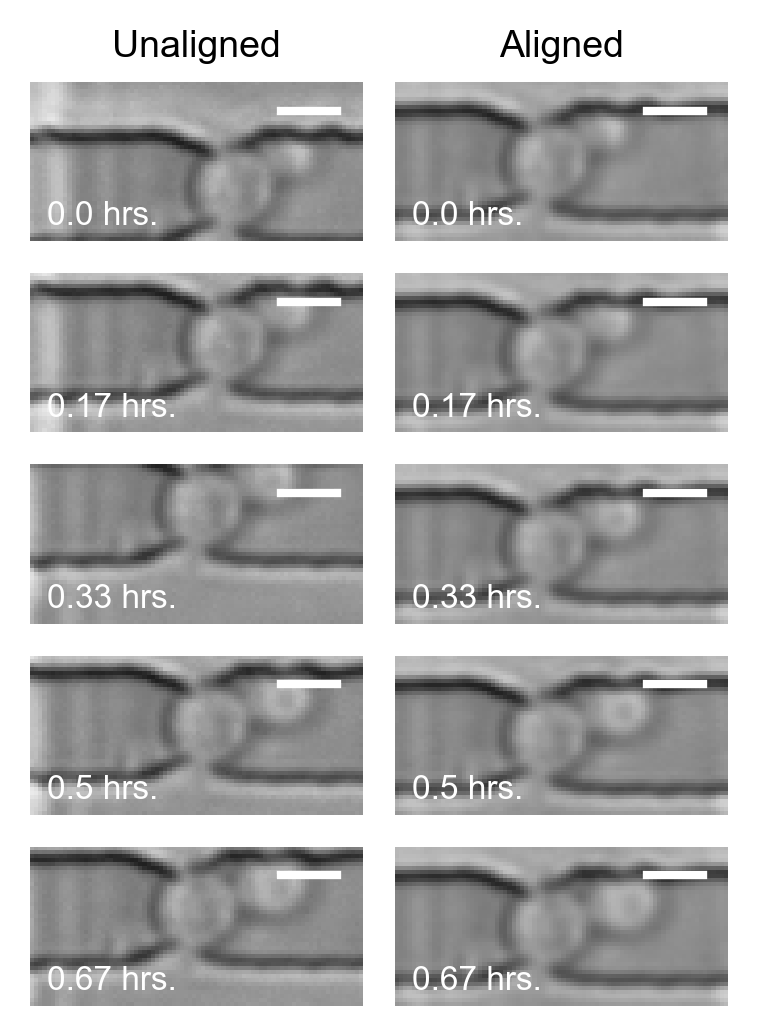

Saved figure at
C:\Users\johnp\Dropbox\Projects\byc\data\meta\plots\title=before_after_alignment.svg


In [69]:
exptname = '20230928_byc'
exptdir = os.path.join(constants.byc_data_dir, exptname)
if a_stack is None:
    aligned_stack_path = os.path.join(exptdir, 'output/20230928_byc_xy00_bf_stack.tif')
    unaligned_stack_path = aligned_stack_path.replace('_stack.tif', '_unaligned_stack.tif')
    a_stack = io.imread(aligned_stack_path)
    u_stack = io.imread(unaligned_stack_path)

n_frames = 5
start_frame = 0
height = 40
width = 80
vmin = 25000
vmax = 62000
# Create data for a scale bar
three_um_in_px = 3/0.22
scale_bar_start_px = (width/6)*4.5
scale_bar_x = np.arange(scale_bar_start_px, scale_bar_start_px + three_um_in_px+0.1, 0.5)
scale_bar_y = np.full_like(scale_bar_x, (height/6)*1)
fig, axs = plt.subplots(nrows=n_frames, ncols=2, figsize=(3, 4))
fig.set_dpi(300)
a_start_y = 190
a_start_x = 20
u_start_y = a_start_y - 26
u_start_x = a_start_x + 16
for frame in range(n_frames):
    # plot unaligned frame
    img_np = np.abs(0-u_stack[frame+start_frame])
    axs[frame, 0].imshow(
        img_np[u_start_y:u_start_y+height, u_start_x:u_start_x+width],
        cmap='Greys',
        aspect = "auto",
        vmin=vmin,
        vmax=vmax
    )
    timestamp = str(np.round(frame*10/60, 2)).zfill(2)
    axs[frame, 0].annotate(
        f'{timestamp} hrs.',
        (0.05, 0.1),
        xycoords='axes fraction',
        color='white',
        fontsize=8)
    axs[frame, 0].axis('off')
    axs[frame, 0].plot(scale_bar_x, scale_bar_y, color='white', linewidth=2)
    if frame == 0:
        axs[frame, 0].set_title('Unaligned', fontsize=9)
    # Plot aligned frame
    img_np = np.abs(0-a_stack[frame+start_frame])
    axs[frame, 1].imshow(
        img_np[a_start_y:a_start_y+height, a_start_x:a_start_x+width],
        cmap='Greys',
        aspect = "auto",
        vmin=vmin,
        vmax=vmax
    )
    timestamp = str(np.round(frame*10/60, 2)).zfill(2)
    axs[frame, 1].annotate(
        f'{timestamp} hrs.',
        (0.05, 0.1),
        xycoords='axes fraction',
        color='white',
        fontsize=8)
    axs[frame, 1].axis('off')
    axs[frame, 1].plot(scale_bar_x, scale_bar_y, color='white', linewidth=2)    
    if frame == 0:
        axs[frame, 1].set_title('Aligned', fontsize=9)
    
# plt.subplots_adjust(hspace=0)
# plt.show()

kwargs = {
    'title': 'before_after_alignment'
}
plt.subplots_adjust(hspace=0.2, wspace=0.1)
plt.show()
plotting.save_figure(fig, kwargs, ext='.svg')

## Segmentation

In [66]:
from byc import utilities, segmentation

### Radial intensity peaks with elliptical smoothing method

Generate data (takes a good amount of time)

In [12]:
compartmentname = "20221201_byc_JPC220_R-YFP-Su9_HSP104-mCherry_full-traces_one_cell"
exptname = compartmentname[0:12]
compartmentdir = files.get_byc_compartmentdir(exptname, compartmentname)
collection_interval_minutes = 10
mdf = utilities.generate_mdf(exptname, compartmentname)
# get_cell_trace_dfs_from_outline_vertices will create binary
# masks stack .tifs as well as measuring fluorescence using
# those masks
celltracedfs = segmentation.get_cell_trace_dfs_from_outline_vertices(
    mdf,
    collection_interval_minutes=collection_interval_minutes,
    save_mask_stack=True
)
# Read in the binary mask stacks created above and smooth
# them into ellipses. Saves smoothed data as outline vertices
# .csv files and as binary mask stacks
for cell_index in mdf.cell_index.unique():
    segmentation.smooth_masks_with_ellipse(
        mdf,
        cell_index,
        plot_visualization=True)
# Use the smoothed ellipse cell outlines to read in 
# fluorescence traces
celltracedfs = segmentation.get_cell_trace_dfs_from_outline_vertices(
    mdf,
    collection_interval_minutes=collection_interval_minutes,
    save_mask_stack=False,
    outline_file_keyword='outline-vertices-ellipse.csv'
)

filename = f'{exptname}_alldf.csv'
tracesavepath = os.path.join(compartmentdir, filename)
traces_df = pd.concat(celltracedfs, ignore_index=True)
traces_df.to_csv(tracesavepath, index=False)
print(f'Saved all cell traces df at\n{tracesavepath}')

Adding paths for channels ['bf', 'rfp', 'yfp']
Found cell indices in compartment
C:\Users\johnp\Dropbox\Projects\byc\data/20221201_byc\20221201_byc_JPC220_R-YFP-Su9_HSP104-mCherry_full-traces_one_cell
[0]
Reading crop stack for cell 0 from
C:\Users\johnp\Dropbox\Projects\byc\data\20221201_byc\20221201_byc_JPC220_R-YFP-Su9_HSP104-mCherry_full-traces_one_cell\20221201_byc_xy00_cell000_bf_stack.tif
Saved mask stack at
C:\Users\johnp\Dropbox\Projects\byc\data\20221201_byc\20221201_byc_JPC220_R-YFP-Su9_HSP104-mCherry_full-traces_one_cell\20221201_byc_xy00_cell000_bf_stack_mask.tif
mp4 saved at
C:\Users\johnp\Dropbox\Projects\byc\data\20221201_byc\20221201_byc_JPC220_R-YFP-Su9_HSP104-mCherry_full-traces_one_cell\20221201_byc_xy00_cell000_bf_stack_mask_ellipse.mp4
Saved smoothed outline vertices to
C:\Users\johnp\Dropbox\Projects\byc\data\20221201_byc\20221201_byc_JPC220_R-YFP-Su9_HSP104-mCherry_full-traces_one_cell\20221201_byc_xy00_cell000_bf_stack_outline-vertices-ellipse.csv
Saved mask st

Plotting

In [13]:
measdfpath = os.path.join(
    compartmentdir,
    f'{compartmentname}_alldf_measured.csv.gzip'
)
measdf = pd.read_csv(measdfpath, compression='gzip')

Saved figure at
C:\Users\johnp\Dropbox\Projects\byc\data\meta\plots\x=radial_distance_y=intensity_mean_norm_hue=theta_alpha=0.7.svg


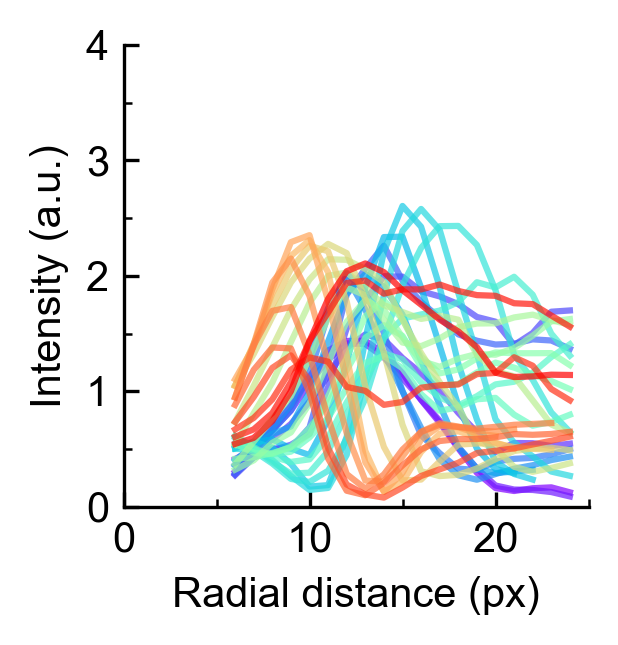

In [15]:
fig, ax = plotting.figure_ax(width_scale=1, height_scale=1)
fig.set_dpi(300)
palettename = 'rainbow'
frame = 48
measdf.loc[:, 'intensity_mean_norm'] = measdf.intensity/measdf.intensity.mean()
kwargs = {
    'x': 'radial_distance',
    'y': 'intensity_mean_norm',
    'hue': 'theta',
    'palette': palettename,
    'data': measdf[measdf.frame==frame],
    'ax': ax,
    'hue_order': measdf.theta.unique(),
    'alpha': 0.7
}
pal = sns.color_palette(kwargs['palette'], measdf.theta.nunique())
sns.lineplot(**kwargs)

# ax.set_ylim(0, 60000)
ax.set_ylim(0, 4)
ax.set_xlim(0, 25)
plotting.format_ticks(ax)
ax.set_xlabel('Radial distance (px)')
ax.set_ylabel('Intensity (a.u.)')
legend = ax.legend(
    ax.get_legend_handles_labels()[0],
    ax.get_legend_handles_labels()[1],
    title = 'Theta (rad)',
    frameon=False,
    fontsize=8,
    bbox_to_anchor=(0.28, 0.9)
)
plt.setp(legend.get_title(),fontsize=9)
ax.legend_.set_visible(False)

plotting.save_figure(fig, kwargs, ext='.svg')

### Cell image with radial slice with width theta

Saved figure at
C:\Users\johnp\Dropbox\Projects\byc\data\meta\plots\title=example_cell_with_radial_slice.svg


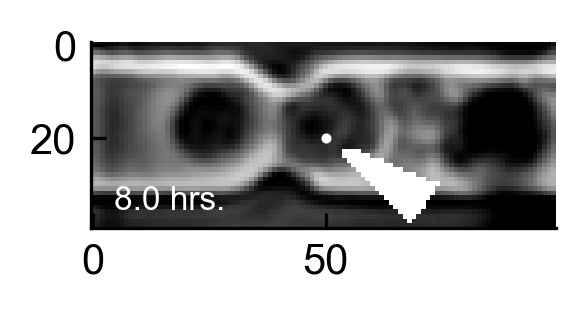

In [17]:
# stack_path = r"C:\Users\johnp\Dropbox\Projects\byc\data\20230928_byc\20230928_byc_JPC146_isolate2_R-YFP-Su9_in_BY4741_low-expr\20230928_byc_xy13_cell002_bf_stack.tif"
bfstack = io.imread(mdf.bf_crop_stack_path[0])
# bfstack = io.imread(stack_path)
img = np.abs(0-bfstack[frame])
center_xy = (img.shape[1]/2, img.shape[0]/2)
# Mask a slice of the image to demonstrate where 
# intensity averages are being taken
R, theta = segmentation.get_polar_coordinates(
    img,
    center_xy[0],
    center_xy[1])

bin_size = np.pi/16
i = 3
min_dist = 5
max_dist = 26
min_theta = i*bin_size - bin_size
max_theta = i*bin_size + bin_size
theta_mask = (np.greater_equal(theta, min_theta) & np.less_equal(theta, max_theta))
rad_mask = (np.greater_equal(R, min_dist) & np.less_equal(R, max_dist))
img_copy = img.copy()
img_copy[rad_mask&theta_mask] = np.max(img)
fig, ax = plotting.figure_ax()
fig.set_dpi(300)
plotting.plot_timestamp(ax, frame)
kwargs = {'title': 'example_cell_with_radial_slice'}
ax.imshow(img_copy, cmap='gray')
# ax.imshow(image_blank)
plotting.format_ticks(ax, add_minor_x=False, add_minor_y=False)
ax.scatter(center_xy[0], center_xy[1], color='white', s=2)
# x = np.arange(center_xy[0]+min_dist, center_xy[0]+max_dist, 1)
# y = np.full_like(x, center_xy[1])
# ax.plot(x, y, color=pal[15], linewidth=1.5)
plotting.save_figure(fig, kwargs, ext='.svg')

### Radial peak values on image

Saved figure at
C:\Users\johnp\Dropbox\Projects\byc\data\meta\plots\title=example_cell_with_radial_peaks_colored_in.svg


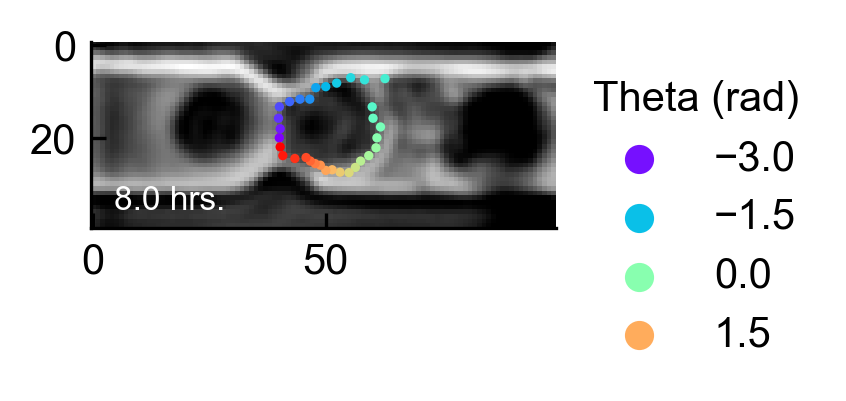

In [297]:
bfstack = io.imread(mdf.bf_crop_stack_path[0])

fig, ax = plotting.figure_ax()
fig.set_dpi(300)
kwargs = {
    'x': 'peak_X',
    'y': 'peak_Y',
    'hue': 'theta',
    'ax': ax,
    'data': measdf[measdf.frame==frame].groupby(
        'theta', as_index=False,
    )[['peak_X', 'peak_Y', 'frame']].median(),
    's': 5,
    'linewidth': 0,
    'palette': 'rainbow'
}
ax.imshow(np.abs(0-bfstack[frame]), cmap='gray')
sns.scatterplot(**kwargs)

ax.legend(
    ax.get_legend_handles_labels()[0],
    ax.get_legend_handles_labels()[1],
    bbox_to_anchor=(1, 1),
    frameon=False,
    title='Theta (rad)'
)
plotting.plot_timestamp(ax, frame)
# ax.legend_.set_visible(False)
plotting.format_ticks(ax, add_minor_x=False, add_minor_y=False)
ax.set_xlabel('')
ax.set_ylabel('')
kwargs = {
    'title': 'example_cell_with_radial_peaks_colored_in'
}
plotting.save_figure(fig, kwargs, ext='.svg')

### Cell with smoothed ellipse outline

Saved figure at
C:\Users\johnp\Dropbox\Projects\byc\data\meta\plots\title=example_cell_with_radial_peaks_colored_in.svg


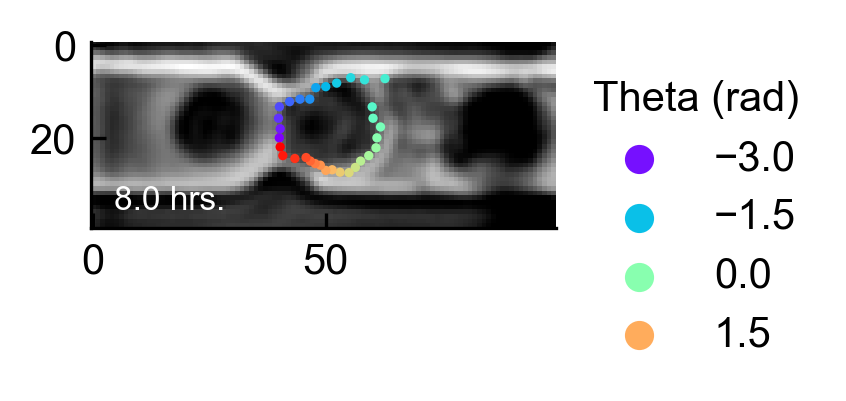

In [358]:
bfstack = io.imread(mdf.bf_crop_stack_path[0])

fig, ax = plotting.figure_ax()
fig.set_dpi(300)
kwargs = {
    'x': 'peak_X',
    'y': 'peak_Y',
    'hue': 'theta',
    'ax': ax,
    'data': measdf[measdf.frame==frame].groupby(
        'theta', as_index=False,
    )[['peak_X', 'peak_Y', 'frame']].median(),
    's': 5,
    'linewidth': 0,
    'palette': 'rainbow'
}
ax.imshow(np.abs(0-bfstack[frame]), cmap='gray')
sns.scatterplot(**kwargs)

ax.legend(
    ax.get_legend_handles_labels()[0],
    ax.get_legend_handles_labels()[1],
    bbox_to_anchor=(1, 1),
    frameon=False,
    title='Theta (rad)'
)
plotting.plot_timestamp(ax, frame)
# ax.legend_.set_visible(False)
plotting.format_ticks(ax, add_minor_x=False, add_minor_y=False)
ax.set_xlabel('')
ax.set_ylabel('')
kwargs = {
    'title': 'example_cell_with_radial_peaks_colored_in'
}
plotting.save_figure(fig, kwargs, ext='.svg')

### Cell with outline drawn 

In [23]:
(44*60)/10

264.0

Saved figure at
C:\Users\johnp\Dropbox\Projects\byc\data\meta\plots\title=frame264_drawn_roi.svg


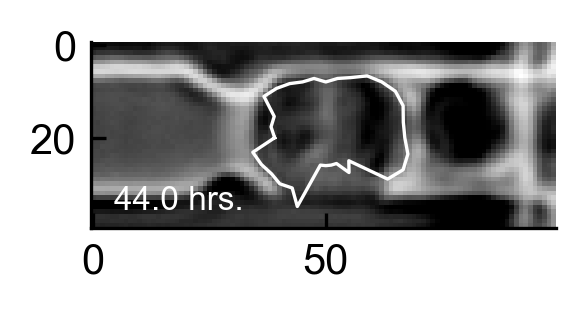

In [24]:
outline_path_ell = mdf.cell_outline_vertices_path[0]
outline_path = outline_path_ell.replace('-ellipse', '')

outlinedf_ell = pd.read_csv(outline_path_ell)
outlinedf = pd.read_csv(outline_path)
frame= 48
frame = 264
img = np.abs(1-bfstack[frame])
xs = list(outlinedf_ell.loc[outlinedf_ell.frame==frame, 'x'])
ys = list(outlinedf_ell.loc[outlinedf_ell.frame==frame, 'y'])
xs = list(outlinedf.loc[outlinedf.frame==frame, 'x'])
ys = list(outlinedf.loc[outlinedf.frame==frame, 'y'])

#repeat the first point to create a 'closed loop'
xs.append(xs[0])
ys.append(ys[0])

fig, ax = plotting.figure_ax()
fig.set_dpi(300)
ax.imshow(img, cmap='gray')
ax.plot(xs, ys, color='white', linewidth=0.8)
plotting.format_ticks(ax, add_minor_x=False, add_minor_y=False)
plotting.plot_timestamp(ax, frame)
plotting.save_figure(fig, {'title': f'frame{frame}_drawn_roi'}, ext='.svg')

### Cell with ellipse smoothed outline drawn

Saved figure at
C:\Users\johnp\Dropbox\Projects\byc\data\meta\plots\title=frame264_drawn_roi_smooth.svg


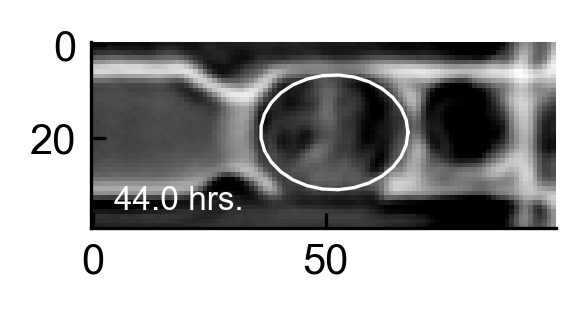

In [25]:
outline_path_ell = mdf.cell_outline_vertices_path[0]
outline_path = outline_path_ell.replace('-ellipse', '')

outlinedf_ell = pd.read_csv(outline_path_ell)
outlinedf = pd.read_csv(outline_path)
frame= 48
frame = 264
img = np.abs(1-bfstack[frame])
xs = list(outlinedf_ell.loc[outlinedf_ell.frame==frame, 'x'])
ys = list(outlinedf_ell.loc[outlinedf_ell.frame==frame, 'y'])
# xs = list(outlinedf.loc[outlinedf.frame==frame, 'x'])
# ys = list(outlinedf.loc[outlinedf.frame==frame, 'y'])

#repeat the first point to create a 'closed loop'
xs.append(xs[0])
ys.append(ys[0])

fig, ax = plotting.figure_ax()
fig.set_dpi(300)
ax.imshow(img, cmap='gray')
ax.plot(xs, ys, color='white', linewidth=0.8)
plotting.format_ticks(ax, add_minor_x=False, add_minor_y=False)
plotting.plot_timestamp(ax, frame)
plotting.save_figure(fig, {'title': f'frame{frame}_drawn_roi_smooth'}, ext='.svg')

### Fluorescence based otsu method

In [2]:
filepath = r"C:\Users\johnp\Dropbox\Projects\byc\data\20190531_byc\20190531_byc_pre9-GFP_pZ4EV-BFP\20190531_byc_xy13_cell002_gfp_stack.tif"
filepath = r"C:\Users\johnp\Dropbox\Projects\byc\data\20230201_byc\20230201_byc_JPC245_Pre6-GFP_BY4741\20230201_byc_xy17_cell006_gfp_stack.tif"
stack = io.imread(filepath)

restricted_roi_width = 11

max_frame = stack.shape[0] - 1
width = stack.shape[2]
height = stack.shape[1]

width_center = int(np.round(width/2, decimals=0))
height_center = int(np.round(height/2, decimals=0))

x_bounds = (width_center - restricted_roi_width, width_center + restricted_roi_width)
y_bounds = (height_center - restricted_roi_width, height_center + restricted_roi_width)

# Segment each frame in the stack using Otsu threshold. Only use data we expect
# to be about within the cell to determine threshold so that we are finding the
# threshold that defines nucleus vs. cytosol and not whole cell vs. background
thresholds = [threshold_otsu(image[y_bounds[0]:y_bounds[1], x_bounds[0]:x_bounds[1]]) for image in stack]
# Find the otsu threshold only within the expected cell area so that we don't segment
# the whole cell, just the nucleus
otsu_masks = [stack[frame] > threshold for frame, threshold in enumerate(thresholds)]
# Watershed isn't really necessary because we're only going to accept
# mask coordinates that are also within the expected cell box
cell_box_masks = np.full_like(stack, False)
cell_box_masks[:, y_bounds[0]:y_bounds[1], x_bounds[0]:x_bounds[1]] = True
nucleus_masks = np.logical_and(otsu_masks, cell_box_masks)
object_labels = [label(frame) for frame in otsu_masks]

Saved figure at
C:\Users\johnp\Dropbox\Projects\byc\data\meta\plots\title=gfp_nuc_with_box.svg


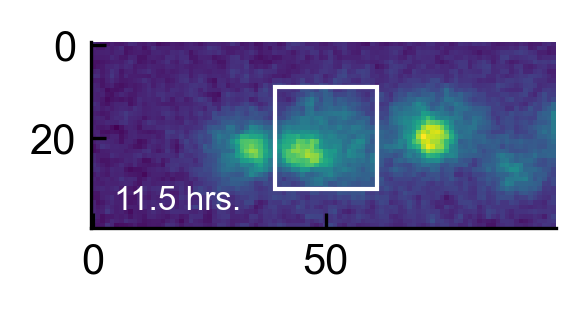

In [3]:
frame_number = 69
fig, ax = plotting.figure_ax()
fig.set_dpi(300)
# frame_number = 106
ax.imshow(stack[frame_number], cmap='viridis')
plotting.plot_timestamp(ax, frame_number)
from matplotlib.patches import Rectangle

rect = Rectangle(
    (50-restricted_roi_width, 20-restricted_roi_width),
    restricted_roi_width*2,
    restricted_roi_width*2,
    facecolor='none',
    alpha=1,
    edgecolor='white')
ax.add_patch(rect)
plotting.format_ticks(ax, add_minor_x=False, add_minor_y=False)
plotting.save_figure(
    fig,
    {'title': 'gfp_nuc_with_box'},
    ext='.svg'
)

Saved figure at
C:\Users\johnp\Dropbox\Projects\byc\data\meta\plots\title=gfp_nuc_labelled_objects.svg


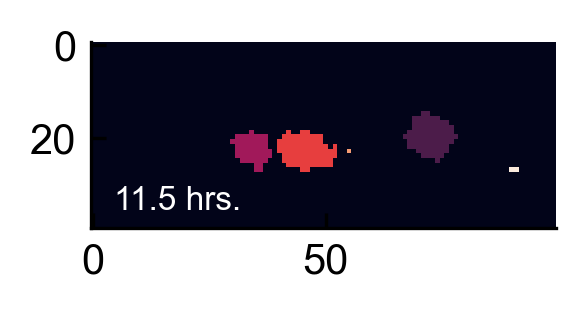

In [4]:
fig, ax = plotting.figure_ax()
fig.set_dpi(300)
ax.imshow(object_labels[frame_number], cmap='rocket')
plotting.plot_timestamp(ax, frame_number)
plotting.format_ticks(ax, add_minor_x=False, add_minor_y=False)
plotting.save_figure(
    fig,
    {'title': 'gfp_nuc_labelled_objects'},
    ext='.svg'
)

In [5]:
from skimage.measure import regionprops_table

properties =['area','bbox','convex_area','bbox_area',
             'major_axis_length', 'minor_axis_length',
             'eccentricity', 'centroid']
df = pd.DataFrame(regionprops_table(object_labels[frame_number], properties = properties))
# We want to be able to use the centroid values as coordinates at some point so round them
# them with 0 decimal places and turn into integers
df.loc[:, 'centroid_x'] = [np.int32(val) for val in np.round(df['centroid-1'], decimals=0)]
df.loc[:, 'centroid_y'] = [np.int32(val) for val in np.round(df['centroid-0'], decimals=0)]
df.loc[:, 'distance_from_center_x'] = np.abs(df.centroid_x - width_center)
df

,area,bbox-0,bbox-1,bbox-2,bbox-3,convex_area,bbox_area,major_axis_length,minor_axis_length,eccentricity,centroid-0,centroid-1,centroid_x,centroid_y,distance_from_center_x
0,79.0,15,67,26,79,90.0,132.0,10.700775,9.594807,0.442748,19.848101,72.493671,72,20,22
1,49.0,19,30,28,39,56.0,81.0,9.005793,7.254422,0.592557,22.714286,34.265306,34,23,16
2,82.0,19,40,28,53,93.0,117.0,13.131699,8.147430,0.784254,23.012195,45.707317,46,23,4
3,1.0,23,55,24,56,1.0,1.0,0.000000,0.000000,0.000000,23.000000,55.000000,55,23,5
4,2.0,27,90,28,92,2.0,2.0,2.000000,0.000000,1.000000,27.000000,90.500000,90,27,40


Saved figure at
C:\Users\johnp\Dropbox\Projects\byc\data\meta\plots\title=gfp_nuc_labelled_objects.svg


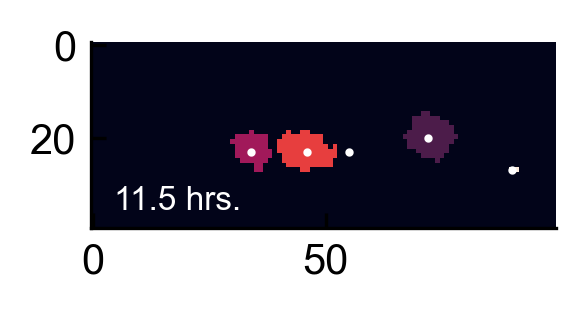

In [6]:
fig, ax = plotting.figure_ax()
fig.set_dpi(300)
ax.imshow(object_labels[frame_number], cmap='rocket')
plotting.plot_timestamp(ax, frame_number)
ax.scatter(df.centroid_x, df.centroid_y, color='white', s=1)
ax.imshow(object_labels[frame_number], cmap='rocket')
plotting.format_ticks(ax, add_minor_x=False, add_minor_y=False)
plotting.save_figure(
    fig,
    {'title': 'gfp_nuc_labelled_objects'},
    ext='.svg'
)

### Draw ROI outline on GFP stack

Saved figure at
C:\Users\johnp\Dropbox\Projects\byc\data\meta\plots\title=gfp_nuc_outline_drawn.svg


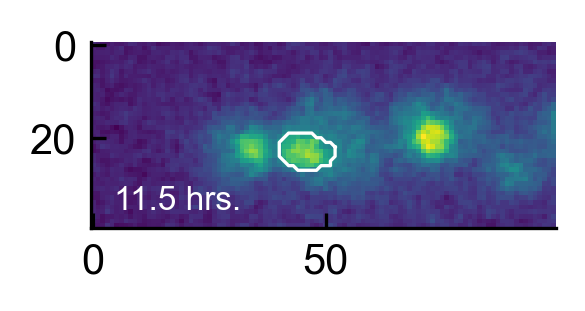

In [9]:
fig, ax = plotting.figure_ax()
fig.set_dpi(300)

sorted_df = df.sort_values(by='distance_from_center_x')
sorted_df.loc[:, 'dist_from_center_rank'] = range(len(sorted_df))
objectdf = sorted_df[sorted_df.dist_from_center_rank==0]
object_index = objectdf.index.unique()[0]
object_value_in_mask = object_index + 1
objectmask = object_labels[frame_number] == object_value_in_mask
poly_x, poly_y = segmentation.get_polygon_vertices_from_mask(objectmask)

ax.imshow(stack[frame_number], cmap='viridis')
ax.plot(poly_x, poly_y, color='white', linewidth=0.8)
plotting.plot_timestamp(ax, frame_number)
plotting.format_ticks(ax, add_minor_x=False, add_minor_y=False)
plotting.save_figure(
    fig,
    {'title': 'gfp_nuc_outline_drawn'},
    ext='.svg'
)

# Chapter 3: Results

# Chapter 4: Discussion